In [178]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.cluster.hierarchy as sch
from bioinfokit import analys, visuz


In [183]:
#Set figure resolution to 300dpi
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [129]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(20, 20))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

In [130]:
def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [159]:
ttests=[]
def ttest(df, df_sub1, df_sub2):
    """
    This function takes two subsetted dataframes where
    protein ID's are along the index and the samples
    you are testing are in the columns, and performs a
    ttest to determine whether each protein in the 
    subsets are at different levels. This function
    returns the original dataframe with a new column 
    for the p-value associated with the t-test. 
    equal_var can be set to True or false depending 
    on whether you need to perform welches correction 
    on the data.
    
    parameters
    ----------
    df: pd.DataFrame
    df_sub1: pd.DataFrame
    df_sub2: pd.DataFrame
    
    returns
    -------
    dataframe with p-values
    
    """
    from scipy.stats import ttest_ind
    df_sub1 = df_sub1.transpose() # Transposition is  required
    df_sub2 = df_sub2.transpose()
    ttests = ttest_ind(df_sub1,df_sub2,equal_var=False,
                       nan_policy='omit')
    ttests = ttests.pvalue.transpose() # Transpose the pvalues back to the original orientation.
    df['ttest_pvalue']=ttests
    return df

In [160]:
def fold(df, sub1, sub2, sub1name, sub2name):
    """
    Creates a new column in your dataframe (df) for fold change between
    two sample types (in separate dataframes sub1 and sub2).
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1 : pd.DataFrame
    sub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Newly formed column in your dataframe.
    """
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Fold Change(%s/%s)' % (sub1name, sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    return df['Fold Change(%s/%s)' % (sub1name, sub2name)]

In [161]:
def piscore(df,sub1name,sub2name):
    """
    pi score is a function which combines outputs from ttest and fold change functions
    and multiplies them to help pick biologically relevant hits within your systems.
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1name : string
    sub2name: string
    
    Returns
    -------
    Newly formed column in your dataframe
    
    
    """
    df['Log2(Fold Change)'] = np.log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']
    return df['%s/%s pi score' % (sub1name,sub2name)]

In [162]:
def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    """
    This function combines previously created user-defined functions to streamline the data
    analysis.
    
    Parameters
    ----------
    dfmain : pd.DataFrame
    dfsub1 : pd.DataFrame
    dfsub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Updated dataframe
    """
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)
    return dfmain

In [131]:
#LOAD DATA
df = pd.read_csv('./CSVExport.csv', index_col=0) #This is the txt file output from PD imported as dataframe "df"


In [132]:
df

,OBJECTID,AMA SITE CODE,Location,STATE,NATTS Site?,Latitude,Longitude,Type,Setting,NATA HAP Name,...,Toluene (µg/m3),Toxaphene (Chlorinated Camphene) (µg/m3),Trichloroethylene (µg/m3),Triethylamine (µg/m3),Trifluralin (µg/m3),Vinyl Acetate (µg/m3),Vinyl Bromide (µg/m3),Vinyl Chloride (µg/m3),Vinylidene Chloride (µg/m3),Xylenes (Mixed Isomers) (µg/m3)
Row Number,,,,,,,,,,,,,,,,,,,,,
1,58,20200018,NaN,AK,0,61.205860,-149.824600,SUBURBAN,NaN,NAPHTHALENE,...,4.203952,NaN,0.009107,0.001888,NaN,0.000064,NaN,0.000116,3.479600e-06,2.273865
2,184,10735503,NaN,AL,0,33.568401,-86.802902,URBAN AND CENTER CITY,NaN,NAPHTHALENE,...,2.093985,NaN,0.031461,0.001022,NaN,0.000046,NaN,0.000492,2.693688e-04,1.157399
3,617,40139997,"Phoenix, AZ",AZ,1,33.503731,-112.095809,URBAN AND CENTER CITY,Urban,NAPHTHALENE,...,3.353296,NaN,0.001794,0.002885,NaN,0.000115,NaN,0.000038,2.795800e-06,1.555841
4,2191,60371103,"Los Angeles, CA",CA,1,34.066590,-118.226880,URBAN AND CENTER CITY,Urban,NAPHTHALENE,...,5.209938,NaN,0.091247,0.002611,NaN,0.000584,NaN,0.000323,1.761010e-05,2.675677
5,2836,60658001,"Rubidoux, CA",CA,1,33.999580,-117.416010,SUBURBAN,Urban,NAPHTHALENE,...,2.660852,NaN,0.043902,0.001325,NaN,0.000136,NaN,0.000292,2.258800e-06,1.408800
6,3629,60850005,"San Jose, CA",CA,1,37.348497,-121.894898,URBAN AND CENTER CITY,Urban,NAPHTHALENE,...,4.363321,NaN,0.084937,0.001901,2.259044e-04,0.004423,NaN,0.002786,8.589450e-05,2.238695
7,4411,80770018,"Grand Junction, CO-18",CO,1,39.064250,-108.561605,URBAN AND CENTER CITY,Urban,NAPHTHALENE,...,1.057804,NaN,0.000413,0.000436,NaN,0.000035,NaN,0.000543,NaN,0.712528
8,4624,110010043,"Washington, DC",DC,1,38.921847,-77.013178,URBAN AND CENTER CITY,Urban,NAPHTHALENE,...,4.141487,NaN,0.007729,0.002597,NaN,0.000183,NaN,0.000354,1.590683e-04,2.209622
9,5393,120573002,"Tampa, FL",FL,1,27.965650,-82.230400,RURAL,Urban,NAPHTHALENE,...,1.454166,NaN,0.000532,0.000620,NaN,0.000041,NaN,0.000205,4.136200e-06,0.762140


# 

In [133]:
#Set the max rows displayed in pandas to no max
pd.set_option('display.max_rows', None)

#View all of the different parameters of the whole dataset as rows 
df.transpose()

Row Number,1,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71
OBJECTID,58,184,617,2191,2836,3629,4411,4624,5393,5693,...,26940,27060,27370,27862,28358,28435,28553,28618,28939,29009
AMA SITE CODE,20200018,10735503,40139997,60371103,60658001,60850005,80770018,110010043,120573002,121030026,...,484790016,490110004,510870014,500070007,530330057,530330080,530530029,530530031,550270001,550270007
Location,NaN,NaN,"Phoenix, AZ","Los Angeles, CA","Rubidoux, CA","San Jose, CA","Grand Junction, CO-18","Washington, DC","Tampa, FL","Pinellas County, FL",...,NaN,"Bountiful, UT","Richmond, VA","Underhill, VT",NaN,"Seattle, WA",NaN,NaN,"Horicon, WI","Mayville, WI"
STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
NATTS Site?,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,0,0,1,1
Latitude,61.20586,33.568401,33.503731,34.06659,33.99958,37.348497,39.06425,38.921847,27.96565,27.850041,...,27.511267,40.902967,37.55655,44.52839,47.55975,47.568333,47.186401,47.265598,43.466111,43.435
Longitude,-149.8246,-86.802902,-112.095809,-118.22688,-117.41601,-121.894898,-108.561605,-77.013178,-82.2304,-82.71459,...,-99.520287,-111.884467,-77.400411,-72.86884,-122.338265,-122.308056,-122.451698,-122.385803,-88.621111,-88.527778
Type,SUBURBAN,URBAN AND CENTER CITY,URBAN AND CENTER CITY,URBAN AND CENTER CITY,SUBURBAN,URBAN AND CENTER CITY,URBAN AND CENTER CITY,URBAN AND CENTER CITY,RURAL,SUBURBAN,...,SUBURBAN,SUBURBAN,SUBURBAN,RURAL,SUBURBAN,URBAN AND CENTER CITY,SUBURBAN,SUBURBAN,RURAL,RURAL
Setting,NaN,NaN,Urban,Urban,Urban,Urban,Urban,Urban,Urban,Urban,...,NaN,Urban,Urban,Rural,NaN,Urban,NaN,NaN,Rural,Rural
NATA HAP Name,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,...,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE,NAPHTHALENE


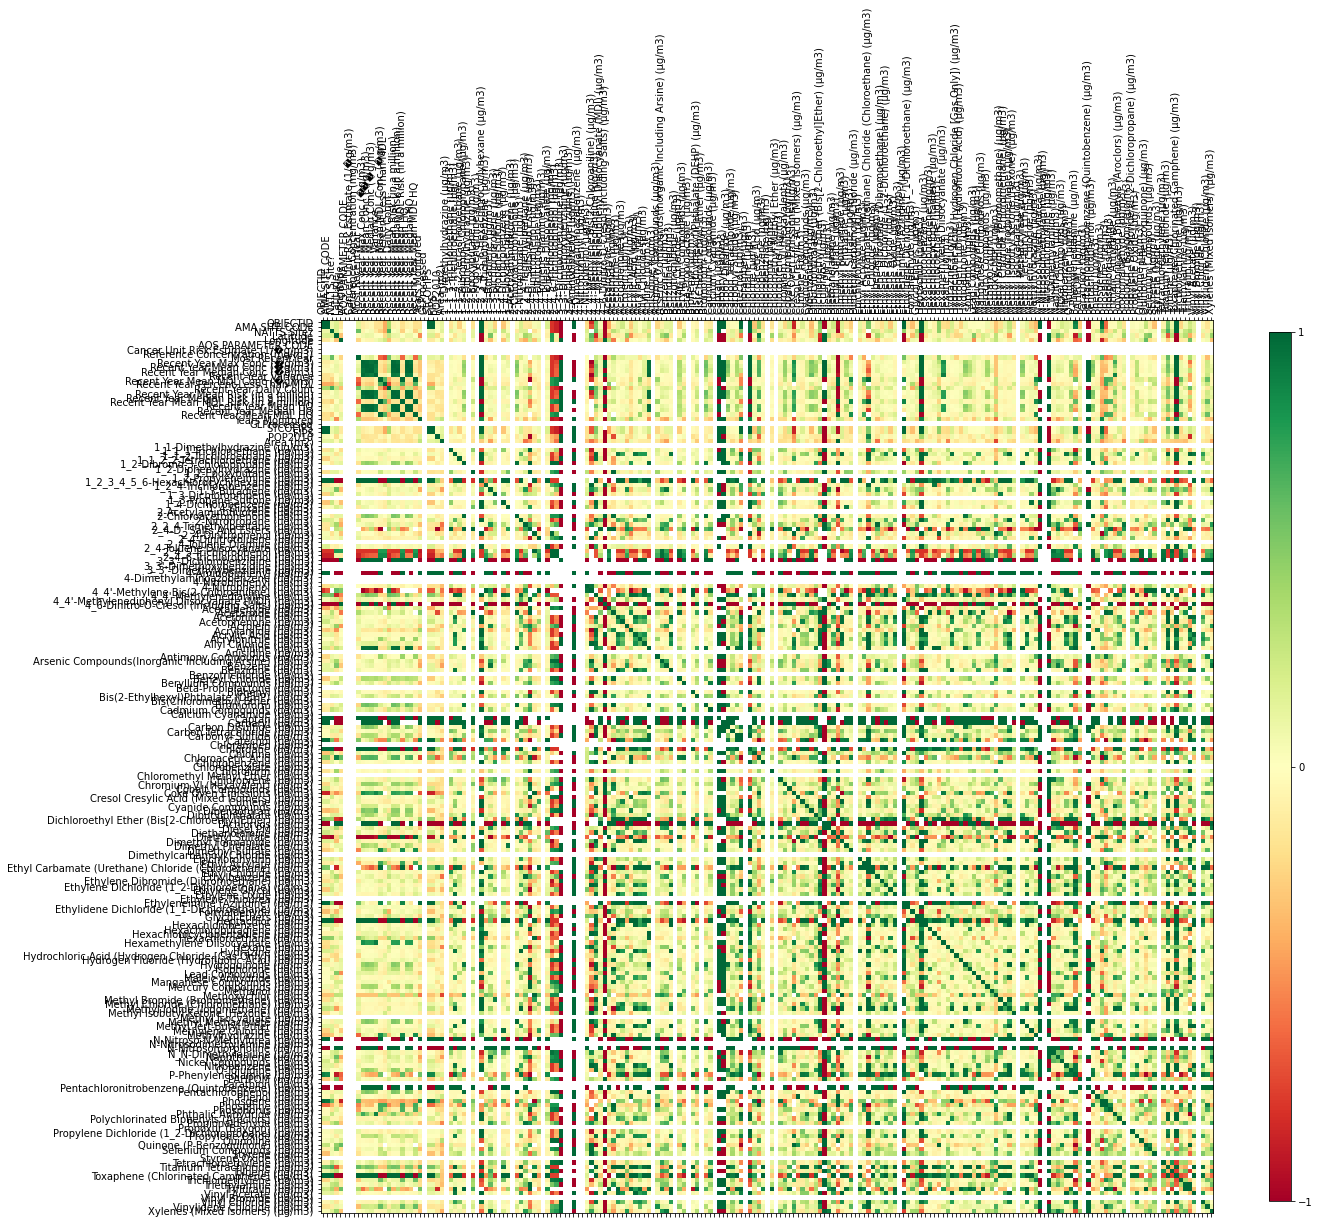

In [134]:
#See what the data looks like in its current form
plot_corr(df)

In [135]:
#Set the max rows displayed in pandas to 10
pd.set_option('display.max_rows', 10)


In [136]:
dft = df.transpose()
dft

Row Number,1,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71
OBJECTID,58,184,617,2191,2836,3629,4411,4624,5393,5693,...,26940,27060,27370,27862,28358,28435,28553,28618,28939,29009
AMA SITE CODE,20200018,10735503,40139997,60371103,60658001,60850005,80770018,110010043,120573002,121030026,...,484790016,490110004,510870014,500070007,530330057,530330080,530530029,530530031,550270001,550270007
Location,NaN,NaN,"Phoenix, AZ","Los Angeles, CA","Rubidoux, CA","San Jose, CA","Grand Junction, CO-18","Washington, DC","Tampa, FL","Pinellas County, FL",...,NaN,"Bountiful, UT","Richmond, VA","Underhill, VT",NaN,"Seattle, WA",NaN,NaN,"Horicon, WI","Mayville, WI"
STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
NATTS Site?,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vinyl Acetate (µg/m3),0.000064,0.000046,0.000115,0.000584,0.000136,0.004423,0.000035,0.000183,0.000041,0.000064,...,0.000039,0.00008,0.000073,0.000065,0.000076,0.000061,0.000066,0.000062,0.000038,0.000057
Vinyl Bromide (µg/m3),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vinyl Chloride (µg/m3),0.000116,0.000492,0.000038,0.000323,0.000292,0.002786,0.000543,0.000354,0.000205,0.005374,...,0.000042,0.000209,0.000279,0.000183,0.000085,0.000087,0.000386,0.000421,0.000147,0.000191
Vinylidene Chloride (µg/m3),0.000003,0.000269,0.000003,0.000018,0.000002,0.000086,NaN,0.000159,0.000004,0.000041,...,0.0,0.000007,0.00001,0.000001,0.000142,0.000048,0.000011,0.000071,0.000001,0.000001


In [137]:
#drop missing values 
dfd = dft.dropna()
dfd

Row Number,1,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71
OBJECTID,58,184,617,2191,2836,3629,4411,4624,5393,5693,...,26940,27060,27370,27862,28358,28435,28553,28618,28939,29009
AMA SITE CODE,20200018,10735503,40139997,60371103,60658001,60850005,80770018,110010043,120573002,121030026,...,484790016,490110004,510870014,500070007,530330057,530330080,530530029,530530031,550270001,550270007
STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
NATTS Site?,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,0,0,1,1
Latitude,61.20586,33.568401,33.503731,34.06659,33.99958,37.348497,39.06425,38.921847,27.96565,27.850041,...,27.511267,40.902967,37.55655,44.52839,47.55975,47.568333,47.186401,47.265598,43.466111,43.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),0.009107,0.031461,0.001794,0.091247,0.043902,0.084937,0.000413,0.007729,0.000532,0.004724,...,0.0042,0.003379,0.00888,0.001364,0.037683,0.047392,0.009594,0.007888,0.005596,0.004473
Triethylamine (µg/m3),0.001888,0.001022,0.002885,0.002611,0.001325,0.001901,0.000436,0.002597,0.00062,0.002122,...,0.000438,0.002608,0.001828,0.000061,0.005738,0.005698,0.00209,0.002064,0.000289,0.000224
Vinyl Acetate (µg/m3),0.000064,0.000046,0.000115,0.000584,0.000136,0.004423,0.000035,0.000183,0.000041,0.000064,...,0.000039,0.00008,0.000073,0.000065,0.000076,0.000061,0.000066,0.000062,0.000038,0.000057
Vinyl Chloride (µg/m3),0.000116,0.000492,0.000038,0.000323,0.000292,0.002786,0.000543,0.000354,0.000205,0.005374,...,0.000042,0.000209,0.000279,0.000183,0.000085,0.000087,0.000386,0.000421,0.000147,0.000191


In [138]:
#set the state row as the column titles
dfd.columns = dfd.iloc[2]
dfd


STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
OBJECTID,58,184,617,2191,2836,3629,4411,4624,5393,5693,...,26940,27060,27370,27862,28358,28435,28553,28618,28939,29009
AMA SITE CODE,20200018,10735503,40139997,60371103,60658001,60850005,80770018,110010043,120573002,121030026,...,484790016,490110004,510870014,500070007,530330057,530330080,530530029,530530031,550270001,550270007
STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
NATTS Site?,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,0,0,1,1
Latitude,61.20586,33.568401,33.503731,34.06659,33.99958,37.348497,39.06425,38.921847,27.96565,27.850041,...,27.511267,40.902967,37.55655,44.52839,47.55975,47.568333,47.186401,47.265598,43.466111,43.435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),0.009107,0.031461,0.001794,0.091247,0.043902,0.084937,0.000413,0.007729,0.000532,0.004724,...,0.0042,0.003379,0.00888,0.001364,0.037683,0.047392,0.009594,0.007888,0.005596,0.004473
Triethylamine (µg/m3),0.001888,0.001022,0.002885,0.002611,0.001325,0.001901,0.000436,0.002597,0.00062,0.002122,...,0.000438,0.002608,0.001828,0.000061,0.005738,0.005698,0.00209,0.002064,0.000289,0.000224
Vinyl Acetate (µg/m3),0.000064,0.000046,0.000115,0.000584,0.000136,0.004423,0.000035,0.000183,0.000041,0.000064,...,0.000039,0.00008,0.000073,0.000065,0.000076,0.000061,0.000066,0.000062,0.000038,0.000057
Vinyl Chloride (µg/m3),0.000116,0.000492,0.000038,0.000323,0.000292,0.002786,0.000543,0.000354,0.000205,0.005374,...,0.000042,0.000209,0.000279,0.000183,0.000085,0.000087,0.000386,0.000421,0.000147,0.000191


In [139]:
#transpose the data which makes state the index column
dfdt = dfd.transpose()
dfdt

,OBJECTID,AMA SITE CODE,STATE,NATTS Site?,Latitude,Longitude,Type,NATA HAP Name,AQS PARAMETER CODE,AQS PARAMETER NAME,...,Propylene Dichloride (1_2-Dichloropropane) (µg/m3),Selenium Compounds (µg/m3),Styrene (µg/m3),Tetrachloroethylene (µg/m3),Toluene (µg/m3),Trichloroethylene (µg/m3),Triethylamine (µg/m3),Vinyl Acetate (µg/m3),Vinyl Chloride (µg/m3),Xylenes (Mixed Isomers) (µg/m3)
STATE,,,,,,,,,,,,,,,,,,,,,
AK,58,20200018,AK,0,61.20586,-149.8246,SUBURBAN,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.000286,0.001009,0.038551,0.031786,4.203952,0.009107,0.001888,0.000064,0.000116,2.273865
AL,184,10735503,AL,0,33.568401,-86.802902,URBAN AND CENTER CITY,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.000068,0.000286,0.023536,0.049028,2.093985,0.031461,0.001022,0.000046,0.000492,1.157399
AZ,617,40139997,AZ,1,33.503731,-112.095809,URBAN AND CENTER CITY,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.000005,0.000204,0.034803,0.143608,3.353296,0.001794,0.002885,0.000115,0.000038,1.555841
CA,2191,60371103,CA,1,34.06659,-118.22688,URBAN AND CENTER CITY,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.000017,0.00029,0.04077,0.88772,5.209938,0.091247,0.002611,0.000584,0.000323,2.675677
CA,2836,60658001,CA,1,33.99958,-117.41601,SUBURBAN,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.000013,0.000298,0.030017,0.392185,2.660852,0.043902,0.001325,0.000136,0.000292,1.4088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WA,28435,530330080,WA,1,47.568333,-122.308056,URBAN AND CENTER CITY,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.00002,0.000801,0.03135,0.229332,12.869431,0.047392,0.005698,0.000061,0.000087,5.725036
WA,28553,530530029,WA,0,47.186401,-122.451698,SUBURBAN,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.00005,0.000208,0.037277,0.085374,6.885934,0.009594,0.00209,0.000066,0.000386,2.161355
WA,28618,530530031,WA,0,47.265598,-122.385803,SUBURBAN,NAPHTHALENE,17141,Naphthalene (total tsp & vapor),...,0.000084,0.000212,0.029734,0.062312,4.277377,0.007888,0.002064,0.000062,0.000421,1.732706


In [140]:
#remove columns that are not float (remove non-numeric values)
cols_to_remove = []

for col in dfdt.columns:
    try:
        _ = dfdt[col].astype(float)
    except ValueError:
        print('Couldn\'t covert %s to float' % col)
        cols_to_remove.append(col)
        pass

# keep only the columns in df that do not contain string
dfdtn = dfdt[[col for col in dfdt.columns if col not in cols_to_remove]]

Couldn't covert STATE to float
Couldn't covert Type to float
Couldn't covert NATA HAP Name to float
Couldn't covert AQS PARAMETER NAME to float
Couldn't covert Pollutant Code Description to float
Couldn't covert Duration Description to float
Couldn't covert Trends Plot to float
Couldn't covert intersected to float
Couldn't covert State to float
Couldn't covert County to float


In [141]:
dfdtn

,OBJECTID,AMA SITE CODE,NATTS Site?,Latitude,Longitude,AQS PARAMETER CODE,Cancer Unit Risk Estimate (1/�g/m3),Reference Concentration (mg/m3),Most RecentYear,Recent Year Max Conc (�g/m3),...,Propylene Dichloride (1_2-Dichloropropane) (µg/m3),Selenium Compounds (µg/m3),Styrene (µg/m3),Tetrachloroethylene (µg/m3),Toluene (µg/m3),Trichloroethylene (µg/m3),Triethylamine (µg/m3),Vinyl Acetate (µg/m3),Vinyl Chloride (µg/m3),Xylenes (Mixed Isomers) (µg/m3)
STATE,,,,,,,,,,,,,,,,,,,,,
AK,58,20200018,0,61.20586,-149.8246,17141,0.000034,0.003,2013,0.31017,...,0.000286,0.001009,0.038551,0.031786,4.203952,0.009107,0.001888,0.000064,0.000116,2.273865
AL,184,10735503,0,33.568401,-86.802902,17141,0.000034,0.003,2012,5.73417,...,0.000068,0.000286,0.023536,0.049028,2.093985,0.031461,0.001022,0.000046,0.000492,1.157399
AZ,617,40139997,1,33.503731,-112.095809,17141,0.000034,0.003,2013,0.28489,...,0.000005,0.000204,0.034803,0.143608,3.353296,0.001794,0.002885,0.000115,0.000038,1.555841
CA,2191,60371103,1,34.06659,-118.22688,17141,0.000034,0.003,2013,0.34986,...,0.000017,0.00029,0.04077,0.88772,5.209938,0.091247,0.002611,0.000584,0.000323,2.675677
CA,2836,60658001,1,33.99958,-117.41601,17141,0.000034,0.003,2013,0.40488,...,0.000013,0.000298,0.030017,0.392185,2.660852,0.043902,0.001325,0.000136,0.000292,1.4088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WA,28435,530330080,1,47.568333,-122.308056,17141,0.000034,0.003,2013,0.21363,...,0.00002,0.000801,0.03135,0.229332,12.869431,0.047392,0.005698,0.000061,0.000087,5.725036
WA,28553,530530029,0,47.186401,-122.451698,17141,0.000034,0.003,2009,0.57627,...,0.00005,0.000208,0.037277,0.085374,6.885934,0.009594,0.00209,0.000066,0.000386,2.161355
WA,28618,530530031,0,47.265598,-122.385803,17141,0.000034,0.003,2009,0.41088,...,0.000084,0.000212,0.029734,0.062312,4.277377,0.007888,0.002064,0.000062,0.000421,1.732706


In [142]:
#transpose the data back to the states being the column titles
df_cool = dfdtn.transpose()
df_cool

STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
OBJECTID,58,184,617,2191,2836,3629,4411,4624,5393,5693,...,26940,27060,27370,27862,28358,28435,28553,28618,28939,29009
AMA SITE CODE,20200018,10735503,40139997,60371103,60658001,60850005,80770018,110010043,120573002,121030026,...,484790016,490110004,510870014,500070007,530330057,530330080,530530029,530530031,550270001,550270007
NATTS Site?,0,0,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,0,0,1,1
Latitude,61.20586,33.568401,33.503731,34.06659,33.99958,37.348497,39.06425,38.921847,27.96565,27.850041,...,27.511267,40.902967,37.55655,44.52839,47.55975,47.568333,47.186401,47.265598,43.466111,43.435
Longitude,-149.8246,-86.802902,-112.095809,-118.22688,-117.41601,-121.894898,-108.561605,-77.013178,-82.2304,-82.71459,...,-99.520287,-111.884467,-77.400411,-72.86884,-122.338265,-122.308056,-122.451698,-122.385803,-88.621111,-88.527778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),0.009107,0.031461,0.001794,0.091247,0.043902,0.084937,0.000413,0.007729,0.000532,0.004724,...,0.0042,0.003379,0.00888,0.001364,0.037683,0.047392,0.009594,0.007888,0.005596,0.004473
Triethylamine (µg/m3),0.001888,0.001022,0.002885,0.002611,0.001325,0.001901,0.000436,0.002597,0.00062,0.002122,...,0.000438,0.002608,0.001828,0.000061,0.005738,0.005698,0.00209,0.002064,0.000289,0.000224
Vinyl Acetate (µg/m3),0.000064,0.000046,0.000115,0.000584,0.000136,0.004423,0.000035,0.000183,0.000041,0.000064,...,0.000039,0.00008,0.000073,0.000065,0.000076,0.000061,0.000066,0.000062,0.000038,0.000057
Vinyl Chloride (µg/m3),0.000116,0.000492,0.000038,0.000323,0.000292,0.002786,0.000543,0.000354,0.000205,0.005374,...,0.000042,0.000209,0.000279,0.000183,0.000085,0.000087,0.000386,0.000421,0.000147,0.000191


In [143]:
#Because we need to log2tranform the data, replace any values with 0 wth NaN and then remove them

dfr = df_cool.replace(0, np.nan)
dfd = dfr.dropna()
dfd

STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
OBJECTID,5.800000e+01,1.840000e+02,6.170000e+02,2.191000e+03,2.836000e+03,3.629000e+03,4.411000e+03,4.624000e+03,5.393000e+03,5.693000e+03,...,2.694000e+04,2.706000e+04,2.737000e+04,2.786200e+04,2.835800e+04,2.843500e+04,2.855300e+04,2.861800e+04,2.893900e+04,2.900900e+04
AMA SITE CODE,2.020002e+07,1.073550e+07,4.014000e+07,6.037110e+07,6.065800e+07,6.085000e+07,8.077002e+07,1.100100e+08,1.205730e+08,1.210300e+08,...,4.847900e+08,4.901100e+08,5.108700e+08,5.000700e+08,5.303301e+08,5.303301e+08,5.305300e+08,5.305300e+08,5.502700e+08,5.502700e+08
Latitude,6.120586e+01,3.356840e+01,3.350373e+01,3.406659e+01,3.399958e+01,3.734850e+01,3.906425e+01,3.892185e+01,2.796565e+01,2.785004e+01,...,2.751127e+01,4.090297e+01,3.755655e+01,4.452839e+01,4.755975e+01,4.756833e+01,4.718640e+01,4.726560e+01,4.346611e+01,4.343500e+01
Longitude,-1.498246e+02,-8.680290e+01,-1.120958e+02,-1.182269e+02,-1.174160e+02,-1.218949e+02,-1.085616e+02,-7.701318e+01,-8.223040e+01,-8.271459e+01,...,-9.952029e+01,-1.118845e+02,-7.740041e+01,-7.286884e+01,-1.223383e+02,-1.223081e+02,-1.224517e+02,-1.223858e+02,-8.862111e+01,-8.852778e+01
AQS PARAMETER CODE,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,...,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04,1.714100e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),9.107143e-03,3.146063e-02,1.793657e-03,9.124746e-02,4.390202e-02,8.493714e-02,4.127111e-04,7.728669e-03,5.318820e-04,4.724357e-03,...,4.199705e-03,3.378735e-03,8.880413e-03,1.364449e-03,3.768296e-02,4.739215e-02,9.594183e-03,7.887639e-03,5.596125e-03,4.472538e-03
Triethylamine (µg/m3),1.887688e-03,1.021939e-03,2.885346e-03,2.611263e-03,1.324932e-03,1.900628e-03,4.360425e-04,2.597352e-03,6.199708e-04,2.122143e-03,...,4.381380e-04,2.607630e-03,1.827558e-03,6.065340e-05,5.738486e-03,5.698109e-03,2.090224e-03,2.063980e-03,2.887166e-04,2.235103e-04
Vinyl Acetate (µg/m3),6.386510e-05,4.622370e-05,1.152101e-04,5.835997e-04,1.361988e-04,4.422519e-03,3.518140e-05,1.827412e-04,4.120650e-05,6.352440e-05,...,3.854790e-05,8.026410e-05,7.347290e-05,6.528740e-05,7.606440e-05,6.127110e-05,6.571450e-05,6.210410e-05,3.752220e-05,5.666160e-05
Vinyl Chloride (µg/m3),1.164062e-04,4.921432e-04,3.769980e-05,3.230410e-04,2.923206e-04,2.786405e-03,5.433590e-04,3.535199e-04,2.048128e-04,5.373625e-03,...,4.171200e-05,2.088477e-04,2.790875e-04,1.826560e-04,8.476690e-05,8.683600e-05,3.858160e-04,4.211008e-04,1.468643e-04,1.910506e-04


In [144]:
#Use numpy to log2transform the data
df_cooler = np.log2(dfd) #log2transforms the data
df_cooler

/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
OBJECTID,5.857981,7.523562,9.269127,11.097374,11.469642,11.825356,12.106890,12.174926,12.396872,12.474973,...,14.717462,14.723874,14.740308,14.766011,14.791468,14.795380,14.801355,14.804635,14.820727,14.824213
AMA SITE CODE,24.267853,23.355886,25.258537,25.847355,25.854195,25.858754,26.267317,26.713060,26.845332,26.850790,...,28.852785,28.868530,28.928381,28.897555,28.982315,28.982315,28.982859,28.982859,29.035564,29.035564
Latitude,5.935598,5.069032,5.066250,5.090286,5.087445,5.222978,5.287777,5.282508,4.805584,4.799608,...,4.781951,5.354134,5.230993,5.476654,5.571669,5.571930,5.560299,5.562719,5.441819,5.440786
Longitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AQS PARAMETER CODE,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,...,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),-6.778786,-4.990309,-9.122880,-3.454072,-4.509569,-3.557461,-11.242580,-7.015564,-10.876606,-7.725666,...,-7.895496,-8.209301,-6.815158,-9.517466,-4.729944,-4.399208,-6.703624,-6.986191,-7.481356,-7.804690
Triethylamine (µg/m3),-9.049164,-9.934475,-8.437040,-8.581037,-9.559866,-9.039308,-11.163244,-8.588743,-10.655512,-8.880263,...,-11.156327,-8.583045,-9.095867,-14.009052,-7.445114,-7.455301,-8.902127,-8.920355,-11.758058,-12.127371
Vinyl Acetate (µg/m3),-13.934613,-14.401008,-13.083445,-10.742733,-12.841998,-7.820916,-14.794828,-12.417910,-14.566769,-13.942330,...,-14.662988,-13.604886,-13.732428,-13.902836,-13.682419,-13.994434,-13.893429,-13.974952,-14.701896,-14.107269
Vinyl Chloride (µg/m3),-13.068544,-10.988634,-14.695084,-11.595995,-11.740161,-8.487379,-10.845807,-11.465921,-12.253406,-7.539889,...,-14.549178,-12.225261,-11.806995,-12.418583,-13.526139,-13.491347,-11.339799,-11.213547,-12.733229,-12.353758


In [145]:
#Drop any datasets that contain NaN after log2 transformation
df_chill = df_cooler.dropna()
df_chill

STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
OBJECTID,5.857981,7.523562,9.269127,11.097374,11.469642,11.825356,12.106890,12.174926,12.396872,12.474973,...,14.717462,14.723874,14.740308,14.766011,14.791468,14.795380,14.801355,14.804635,14.820727,14.824213
AMA SITE CODE,24.267853,23.355886,25.258537,25.847355,25.854195,25.858754,26.267317,26.713060,26.845332,26.850790,...,28.852785,28.868530,28.928381,28.897555,28.982315,28.982315,28.982859,28.982859,29.035564,29.035564
Latitude,5.935598,5.069032,5.066250,5.090286,5.087445,5.222978,5.287777,5.282508,4.805584,4.799608,...,4.781951,5.354134,5.230993,5.476654,5.571669,5.571930,5.560299,5.562719,5.441819,5.440786
AQS PARAMETER CODE,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,...,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164
Cancer Unit Risk Estimate (1/�g/m3),-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,...,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Trichloroethylene (µg/m3),-6.778786,-4.990309,-9.122880,-3.454072,-4.509569,-3.557461,-11.242580,-7.015564,-10.876606,-7.725666,...,-7.895496,-8.209301,-6.815158,-9.517466,-4.729944,-4.399208,-6.703624,-6.986191,-7.481356,-7.804690
Triethylamine (µg/m3),-9.049164,-9.934475,-8.437040,-8.581037,-9.559866,-9.039308,-11.163244,-8.588743,-10.655512,-8.880263,...,-11.156327,-8.583045,-9.095867,-14.009052,-7.445114,-7.455301,-8.902127,-8.920355,-11.758058,-12.127371
Vinyl Acetate (µg/m3),-13.934613,-14.401008,-13.083445,-10.742733,-12.841998,-7.820916,-14.794828,-12.417910,-14.566769,-13.942330,...,-14.662988,-13.604886,-13.732428,-13.902836,-13.682419,-13.994434,-13.893429,-13.974952,-14.701896,-14.107269
Vinyl Chloride (µg/m3),-13.068544,-10.988634,-14.695084,-11.595995,-11.740161,-8.487379,-10.845807,-11.465921,-12.253406,-7.539889,...,-14.549178,-12.225261,-11.806995,-12.418583,-13.526139,-13.491347,-11.339799,-11.213547,-12.733229,-12.353758


array([[<AxesSubplot:title={'center':'AK'}>,
        <AxesSubplot:title={'center':'AL'}>,
        <AxesSubplot:title={'center':'AZ'}>,
        <AxesSubplot:title={'center':'CA'}>,
        <AxesSubplot:title={'center':'CA'}>,
        <AxesSubplot:title={'center':'CA'}>,
        <AxesSubplot:title={'center':'CO'}>,
        <AxesSubplot:title={'center':'DC'}>],
       [<AxesSubplot:title={'center':'FL'}>,
        <AxesSubplot:title={'center':'FL'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>],
       [<AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        <AxesSubplot:title={'center':'GA'}>,
        

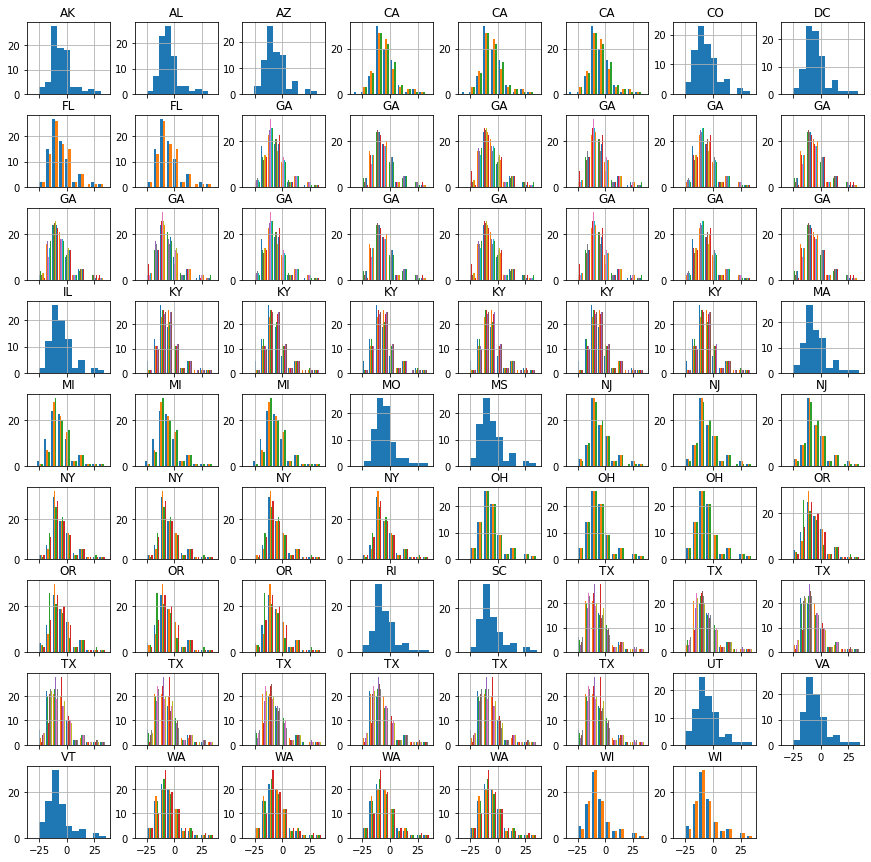

In [146]:
#View the distribution of each column
df_chill.hist(figsize=(15,15), sharex = True)

<AxesSubplot:xlabel='STATE', ylabel='STATE'>

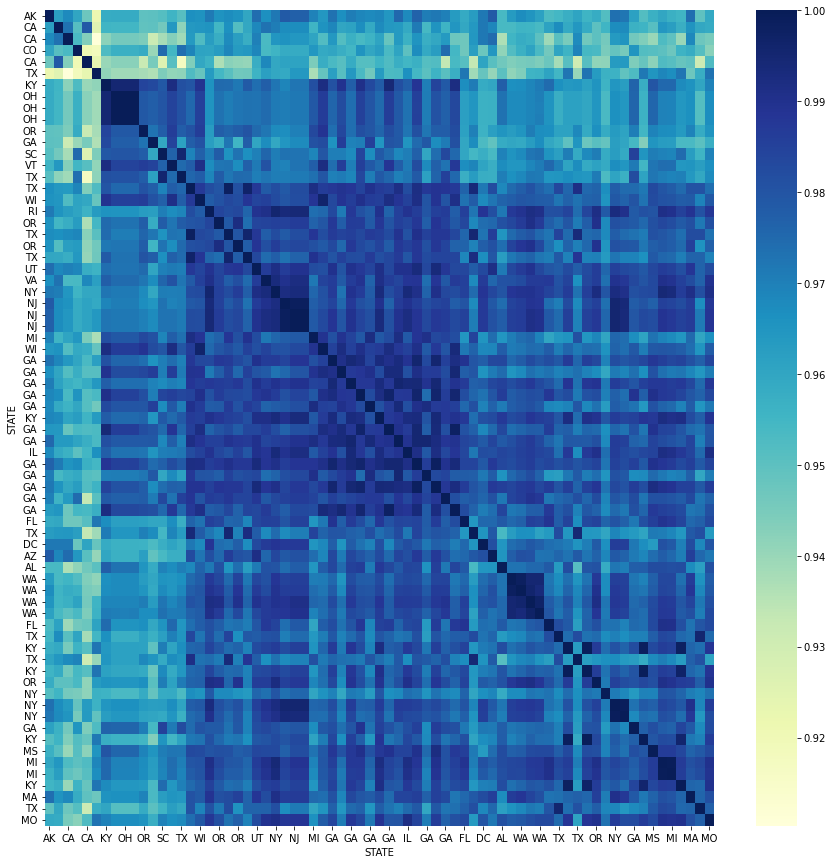

In [147]:
#view a correlation clusterplot of the data if you like that sort of thing

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(cluster_corr(df_chill.corr()), cmap='YlGnBu', ax=ax)

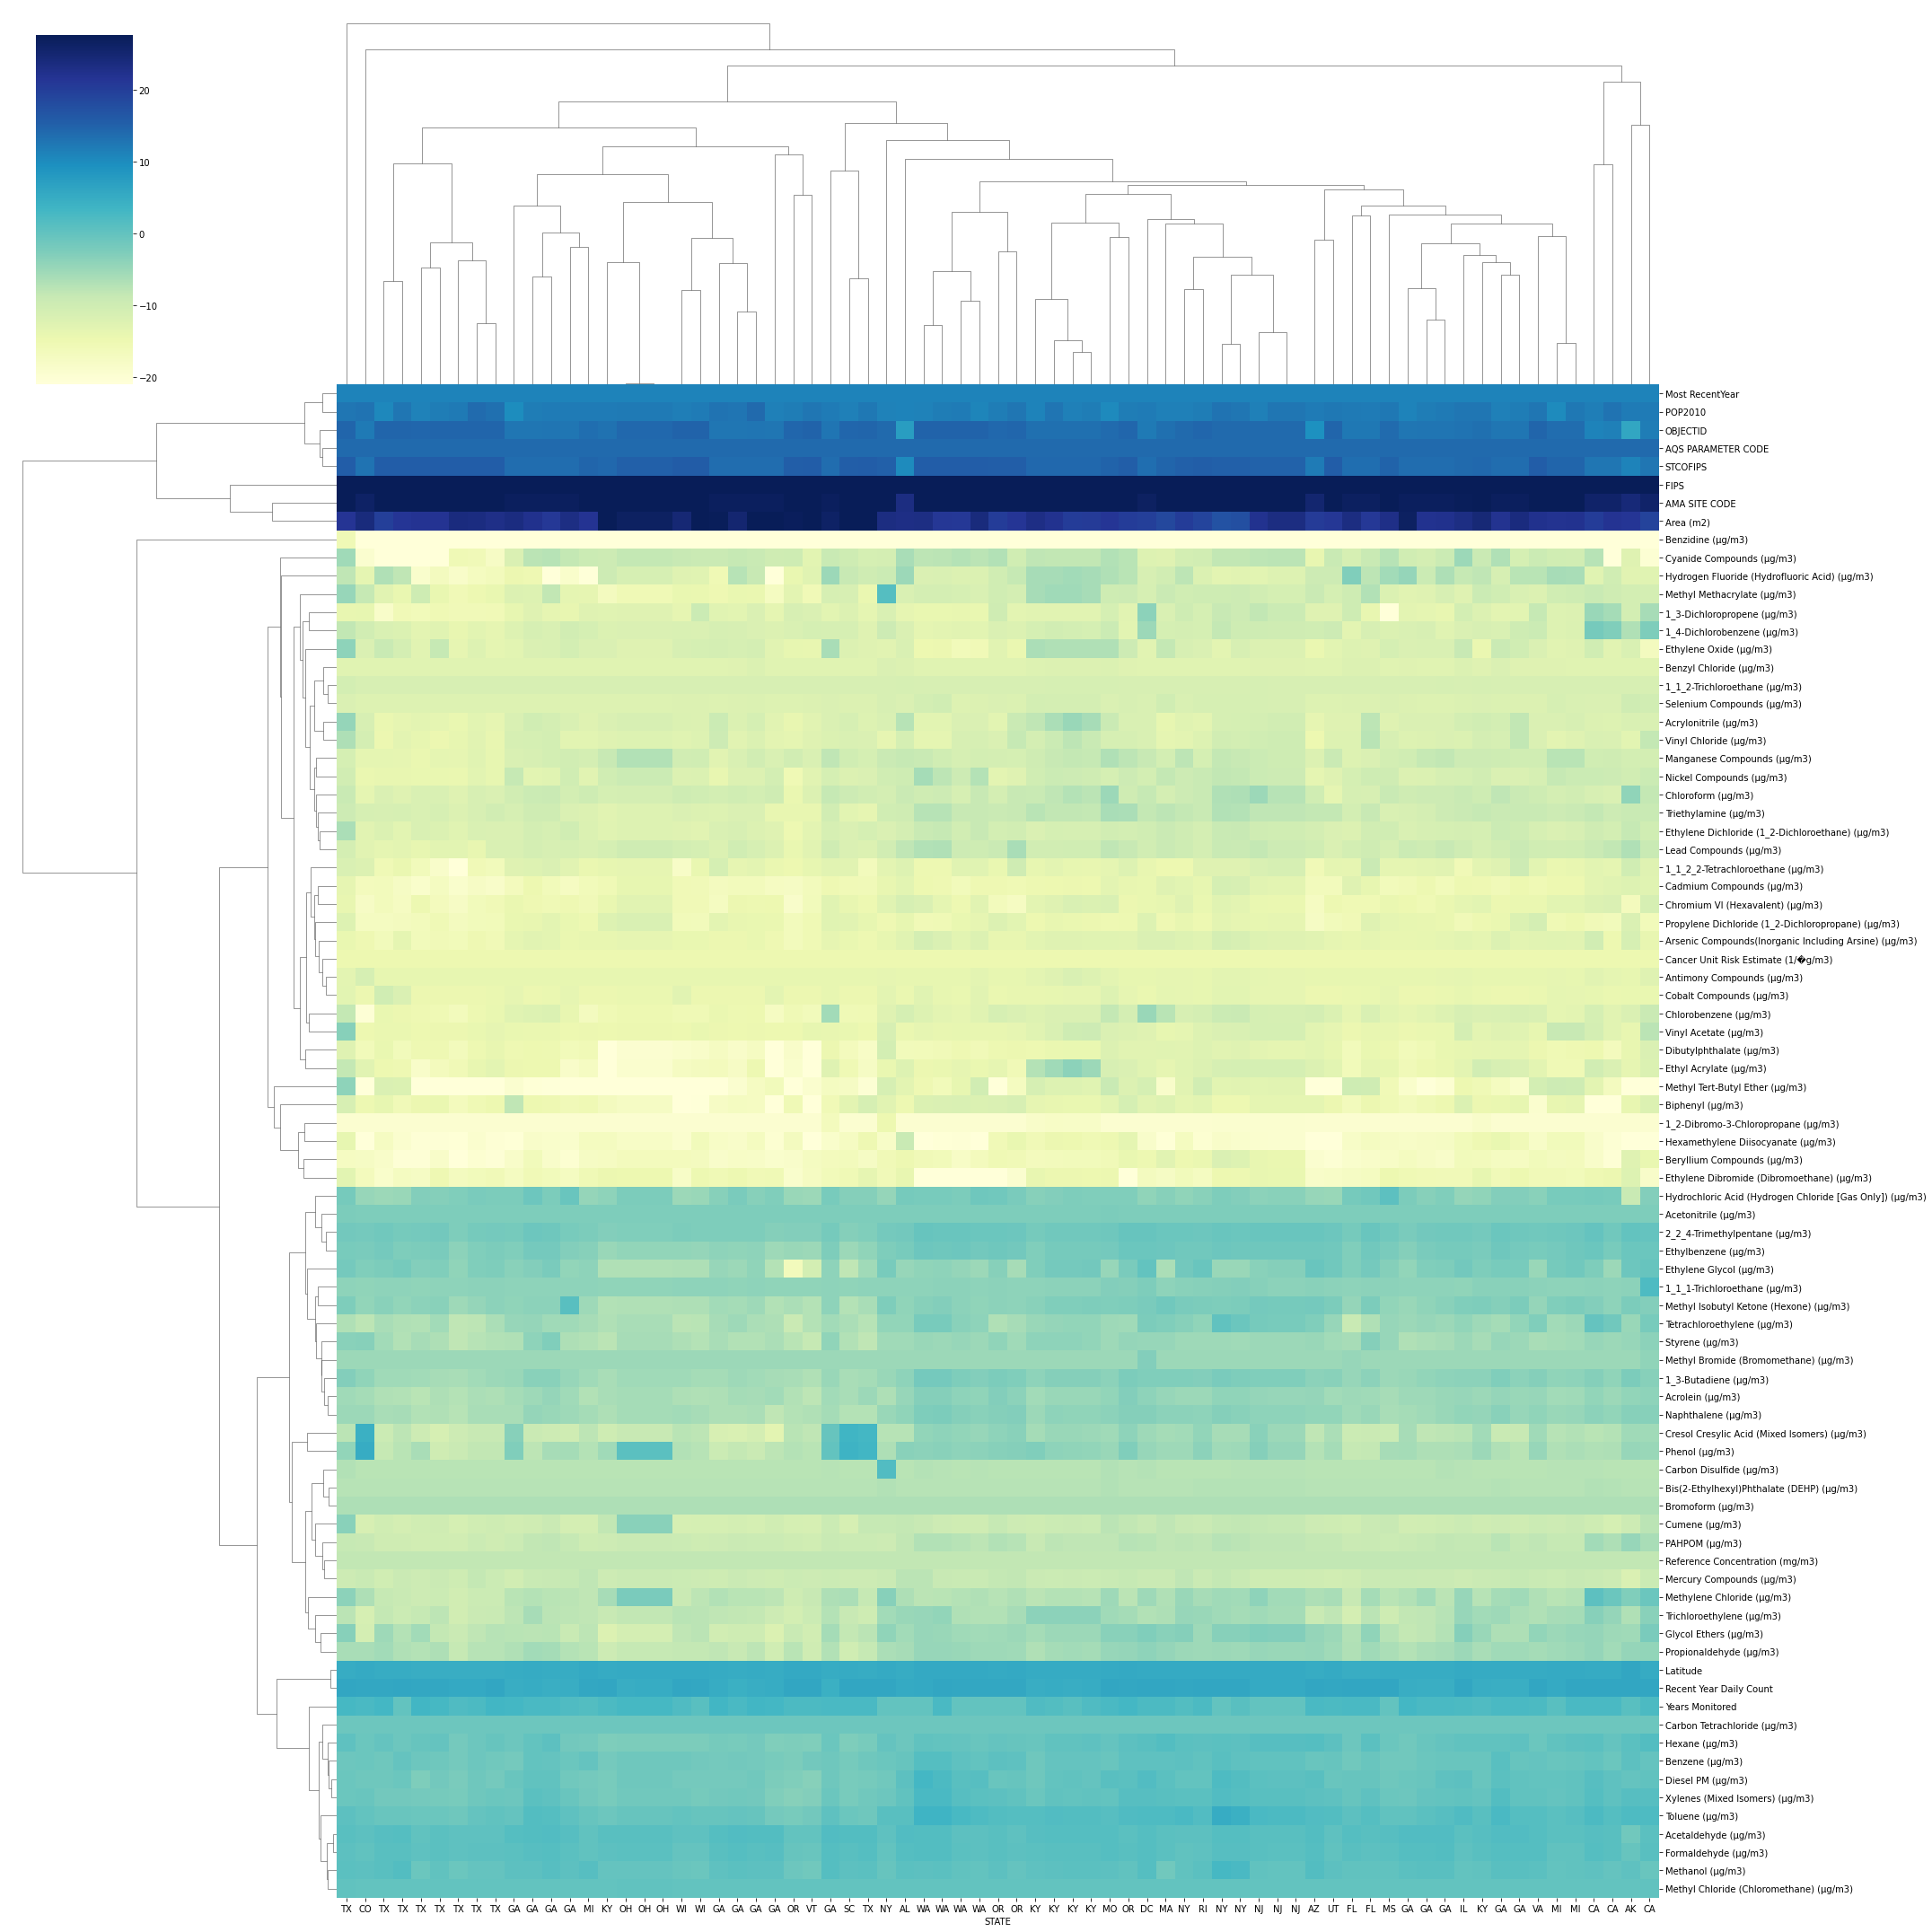

In [148]:
#heirarchical clustering of dataset
sns.clustermap(df_chill, robust = True, figsize=(30,30), cmap = "YlGnBu")

In [149]:
#Set the max rows displayed in pandas to no max
pd.set_option('display.max_rows', None)

In [150]:
#View the top 15 rows
df_chill.head(15)

STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
OBJECTID,5.857981,7.523562,9.269127,11.097374,11.469642,11.825356,12.106890,12.174926,12.396872,12.474973,...,14.717462,14.723874,14.740308,14.766011,14.791468,14.795380,14.801355,14.804635,14.820727,14.824213
AMA SITE CODE,24.267853,23.355886,25.258537,25.847355,25.854195,25.858754,26.267317,26.713060,26.845332,26.850790,...,28.852785,28.868530,28.928381,28.897555,28.982315,28.982315,28.982859,28.982859,29.035564,29.035564
Latitude,5.935598,5.069032,5.066250,5.090286,5.087445,5.222978,5.287777,5.282508,4.805584,4.799608,...,4.781951,5.354134,5.230993,5.476654,5.571669,5.571930,5.560299,5.562719,5.441819,5.440786
AQS PARAMETER CODE,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,...,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164
Cancer Unit Risk Estimate (1/�g/m3),-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,...,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106
Reference Concentration (mg/m3),-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,...,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822
Most RecentYear,10.975131,10.974415,10.975131,10.975131,10.975131,10.975131,10.975131,10.975131,10.975131,10.975131,...,10.972980,10.975131,10.975131,10.975131,10.972262,10.975131,10.972262,10.972262,10.975131,10.972262
Recent Year Daily Count,5.954196,5.392317,5.857981,5.857981,5.857981,5.882643,5.807355,5.906891,5.882643,5.882643,...,5.672425,5.807355,5.857981,5.882643,5.614710,5.832890,5.643856,5.672425,5.930737,5.807355
Years Monitored,1.000000,0.000000,2.584963,2.584963,2.584963,2.321928,2.584963,2.321928,2.584963,2.584963,...,2.807355,2.321928,2.321928,2.321928,0.000000,2.584963,0.000000,0.000000,2.000000,1.000000
STCOFIPS,10.980140,10.067434,11.970465,12.559616,12.566292,12.571042,12.979604,13.425347,13.557583,13.563077,...,15.565072,15.580818,15.640669,15.609842,15.694603,15.694603,15.695147,15.695147,15.747852,15.747852


In [151]:
df_c = df_chill.reset_index()
df_c

STATE,index,AK,AL,AZ,CA,CA,CA,CO,DC,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
0,OBJECTID,5.857981,7.523562,9.269127,11.097374,11.469642,11.825356,12.106890,12.174926,12.396872,...,14.717462,14.723874,14.740308,14.766011,14.791468,14.795380,14.801355,14.804635,14.820727,14.824213
1,AMA SITE CODE,24.267853,23.355886,25.258537,25.847355,25.854195,25.858754,26.267317,26.713060,26.845332,...,28.852785,28.868530,28.928381,28.897555,28.982315,28.982315,28.982859,28.982859,29.035564,29.035564
2,Latitude,5.935598,5.069032,5.066250,5.090286,5.087445,5.222978,5.287777,5.282508,4.805584,...,4.781951,5.354134,5.230993,5.476654,5.571669,5.571930,5.560299,5.562719,5.441819,5.440786
3,AQS PARAMETER CODE,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,...,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164,14.065164
4,Cancer Unit Risk Estimate (1/�g/m3),-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,...,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106,-14.844106
5,Reference Concentration (mg/m3),-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,...,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822,-8.380822
6,Most RecentYear,10.975131,10.974415,10.975131,10.975131,10.975131,10.975131,10.975131,10.975131,10.975131,...,10.972980,10.975131,10.975131,10.975131,10.972262,10.975131,10.972262,10.972262,10.975131,10.972262
7,Recent Year Daily Count,5.954196,5.392317,5.857981,5.857981,5.857981,5.882643,5.807355,5.906891,5.882643,...,5.672425,5.807355,5.857981,5.882643,5.614710,5.832890,5.643856,5.672425,5.930737,5.807355
8,Years Monitored,1.000000,0.000000,2.584963,2.584963,2.584963,2.321928,2.584963,2.321928,2.584963,...,2.807355,2.321928,2.321928,2.321928,0.000000,2.584963,0.000000,0.000000,2.000000,1.000000
9,STCOFIPS,10.980140,10.067434,11.970465,12.559616,12.566292,12.571042,12.979604,13.425347,13.557583,...,15.565072,15.580818,15.640669,15.609842,15.694603,15.694603,15.695147,15.695147,15.747852,15.747852


In [152]:
#remove the non-chemical data (top 12 rows)
data = df_c.drop(range(0,13))
data

STATE,index,AK,AL,AZ,CA,CA,CA,CO,DC,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
13,1_1_1-Trichloroethane (µg/m3),-3.796887,-3.969953,-3.628549,-3.691659,-3.958038,2.172166,-4.058894,-2.643089,-4.008687,...,-4.024433,-3.663098,-3.729315,-4.058518,-3.867341,-3.844676,-3.769895,-3.871994,-4.037055,-4.028913
14,1_1_2-Trichloroethane (µg/m3),-11.338465,-11.243084,-11.338482,-11.298838,-11.336614,-11.338501,-11.335073,-11.336866,-11.338495,...,-11.321190,-11.338465,-11.333957,-11.338499,-11.337045,-11.338013,-11.338456,-11.337949,-11.338490,-11.338292
15,1_1_2_2-Tetrachloroethane (µg/m3),-10.217871,-12.297899,-15.756331,-12.990007,-13.452792,-12.453104,-12.102761,-13.958841,-13.680923,...,-18.510574,-13.431661,-13.117491,-13.841973,-14.953249,-14.920073,-12.687180,-12.617442,-18.138880,-14.235909
16,1_2-Dibromo-3-Chloropropane (µg/m3),-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,...,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592
17,1_3-Butadiene (µg/m3),-2.340012,-3.927546,-3.727048,-3.182316,-4.225048,-3.287228,-4.146058,-2.756964,-4.644116,...,-6.044512,-3.611149,-3.245413,-6.722766,-1.679886,-1.595628,-2.573657,-3.075451,-5.383198,-5.825888
18,1_3-Dichloropropene (µg/m3),-10.648289,-13.544534,-12.585733,-4.927887,-5.871919,-6.020687,-13.833838,-3.733962,-9.750723,...,-15.323020,-12.459590,-8.754134,-11.803050,-14.236351,-14.223086,-14.030373,-14.145221,-13.586153,-9.488576
19,1_4-Dichlorobenzene (µg/m3),-6.753184,-11.692039,-10.224865,-1.876380,-2.786328,-2.552992,-10.435447,-5.172656,-13.320547,...,-12.603076,-9.734505,-9.486649,-10.957095,-13.470012,-13.235477,-12.920360,-13.024263,-11.475933,-11.806463
20,2_2_4-Trimethylpentane (µg/m3),0.093651,-1.430071,-0.507488,-0.163373,-1.221850,-0.171511,-1.615615,-0.288660,-1.792319,...,-1.503430,-0.829054,-1.343658,-2.998767,-0.342494,-0.472807,-0.491535,-0.773034,-2.468366,-2.687659
21,Acetaldehyde (µg/m3),-1.229480,1.711477,1.633853,1.122677,0.922019,0.768978,0.676393,1.375001,1.351475,...,0.856128,0.442855,1.462948,0.104735,1.627939,1.621608,0.677962,0.616337,0.365015,0.337054
22,Acetonitrile (µg/m3),-2.556369,-2.556387,-2.556380,-2.556290,-2.556393,-2.548995,-2.556393,-2.555287,-2.556389,...,-2.556392,-2.556369,-2.555379,-2.556347,-2.555376,-2.556022,-2.555973,-2.551768,-2.556386,-2.556384


In [153]:
#reset chemicals as column index
data_clean = data.set_index('index')
data_clean

STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
index,,,,,,,,,,,,,,,,,,,,,
1_1_1-Trichloroethane (µg/m3),-3.796887,-3.969953,-3.628549,-3.691659,-3.958038,2.172166,-4.058894,-2.643089,-4.008687,-3.798316,...,-4.024433,-3.663098,-3.729315,-4.058518,-3.867341,-3.844676,-3.769895,-3.871994,-4.037055,-4.028913
1_1_2-Trichloroethane (µg/m3),-11.338465,-11.243084,-11.338482,-11.298838,-11.336614,-11.338501,-11.335073,-11.336866,-11.338495,-11.338500,...,-11.321190,-11.338465,-11.333957,-11.338499,-11.337045,-11.338013,-11.338456,-11.337949,-11.338490,-11.338292
1_1_2_2-Tetrachloroethane (µg/m3),-10.217871,-12.297899,-15.756331,-12.990007,-13.452792,-12.453104,-12.102761,-13.958841,-13.680923,-9.355322,...,-18.510574,-13.431661,-13.117491,-13.841973,-14.953249,-14.920073,-12.687180,-12.617442,-18.138880,-14.235909
1_2-Dibromo-3-Chloropropane (µg/m3),-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,...,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592
1_3-Butadiene (µg/m3),-2.340012,-3.927546,-3.727048,-3.182316,-4.225048,-3.287228,-4.146058,-2.756964,-4.644116,-3.817412,...,-6.044512,-3.611149,-3.245413,-6.722766,-1.679886,-1.595628,-2.573657,-3.075451,-5.383198,-5.825888
1_3-Dichloropropene (µg/m3),-10.648289,-13.544534,-12.585733,-4.927887,-5.871919,-6.020687,-13.833838,-3.733962,-9.750723,-14.067893,...,-15.323020,-12.459590,-8.754134,-11.803050,-14.236351,-14.223086,-14.030373,-14.145221,-13.586153,-9.488576
1_4-Dichlorobenzene (µg/m3),-6.753184,-11.692039,-10.224865,-1.876380,-2.786328,-2.552992,-10.435447,-5.172656,-13.320547,-11.409585,...,-12.603076,-9.734505,-9.486649,-10.957095,-13.470012,-13.235477,-12.920360,-13.024263,-11.475933,-11.806463
2_2_4-Trimethylpentane (µg/m3),0.093651,-1.430071,-0.507488,-0.163373,-1.221850,-0.171511,-1.615615,-0.288660,-1.792319,-0.608884,...,-1.503430,-0.829054,-1.343658,-2.998767,-0.342494,-0.472807,-0.491535,-0.773034,-2.468366,-2.687659
Acetaldehyde (µg/m3),-1.229480,1.711477,1.633853,1.122677,0.922019,0.768978,0.676393,1.375001,1.351475,1.010048,...,0.856128,0.442855,1.462948,0.104735,1.627939,1.621608,0.677962,0.616337,0.365015,0.337054


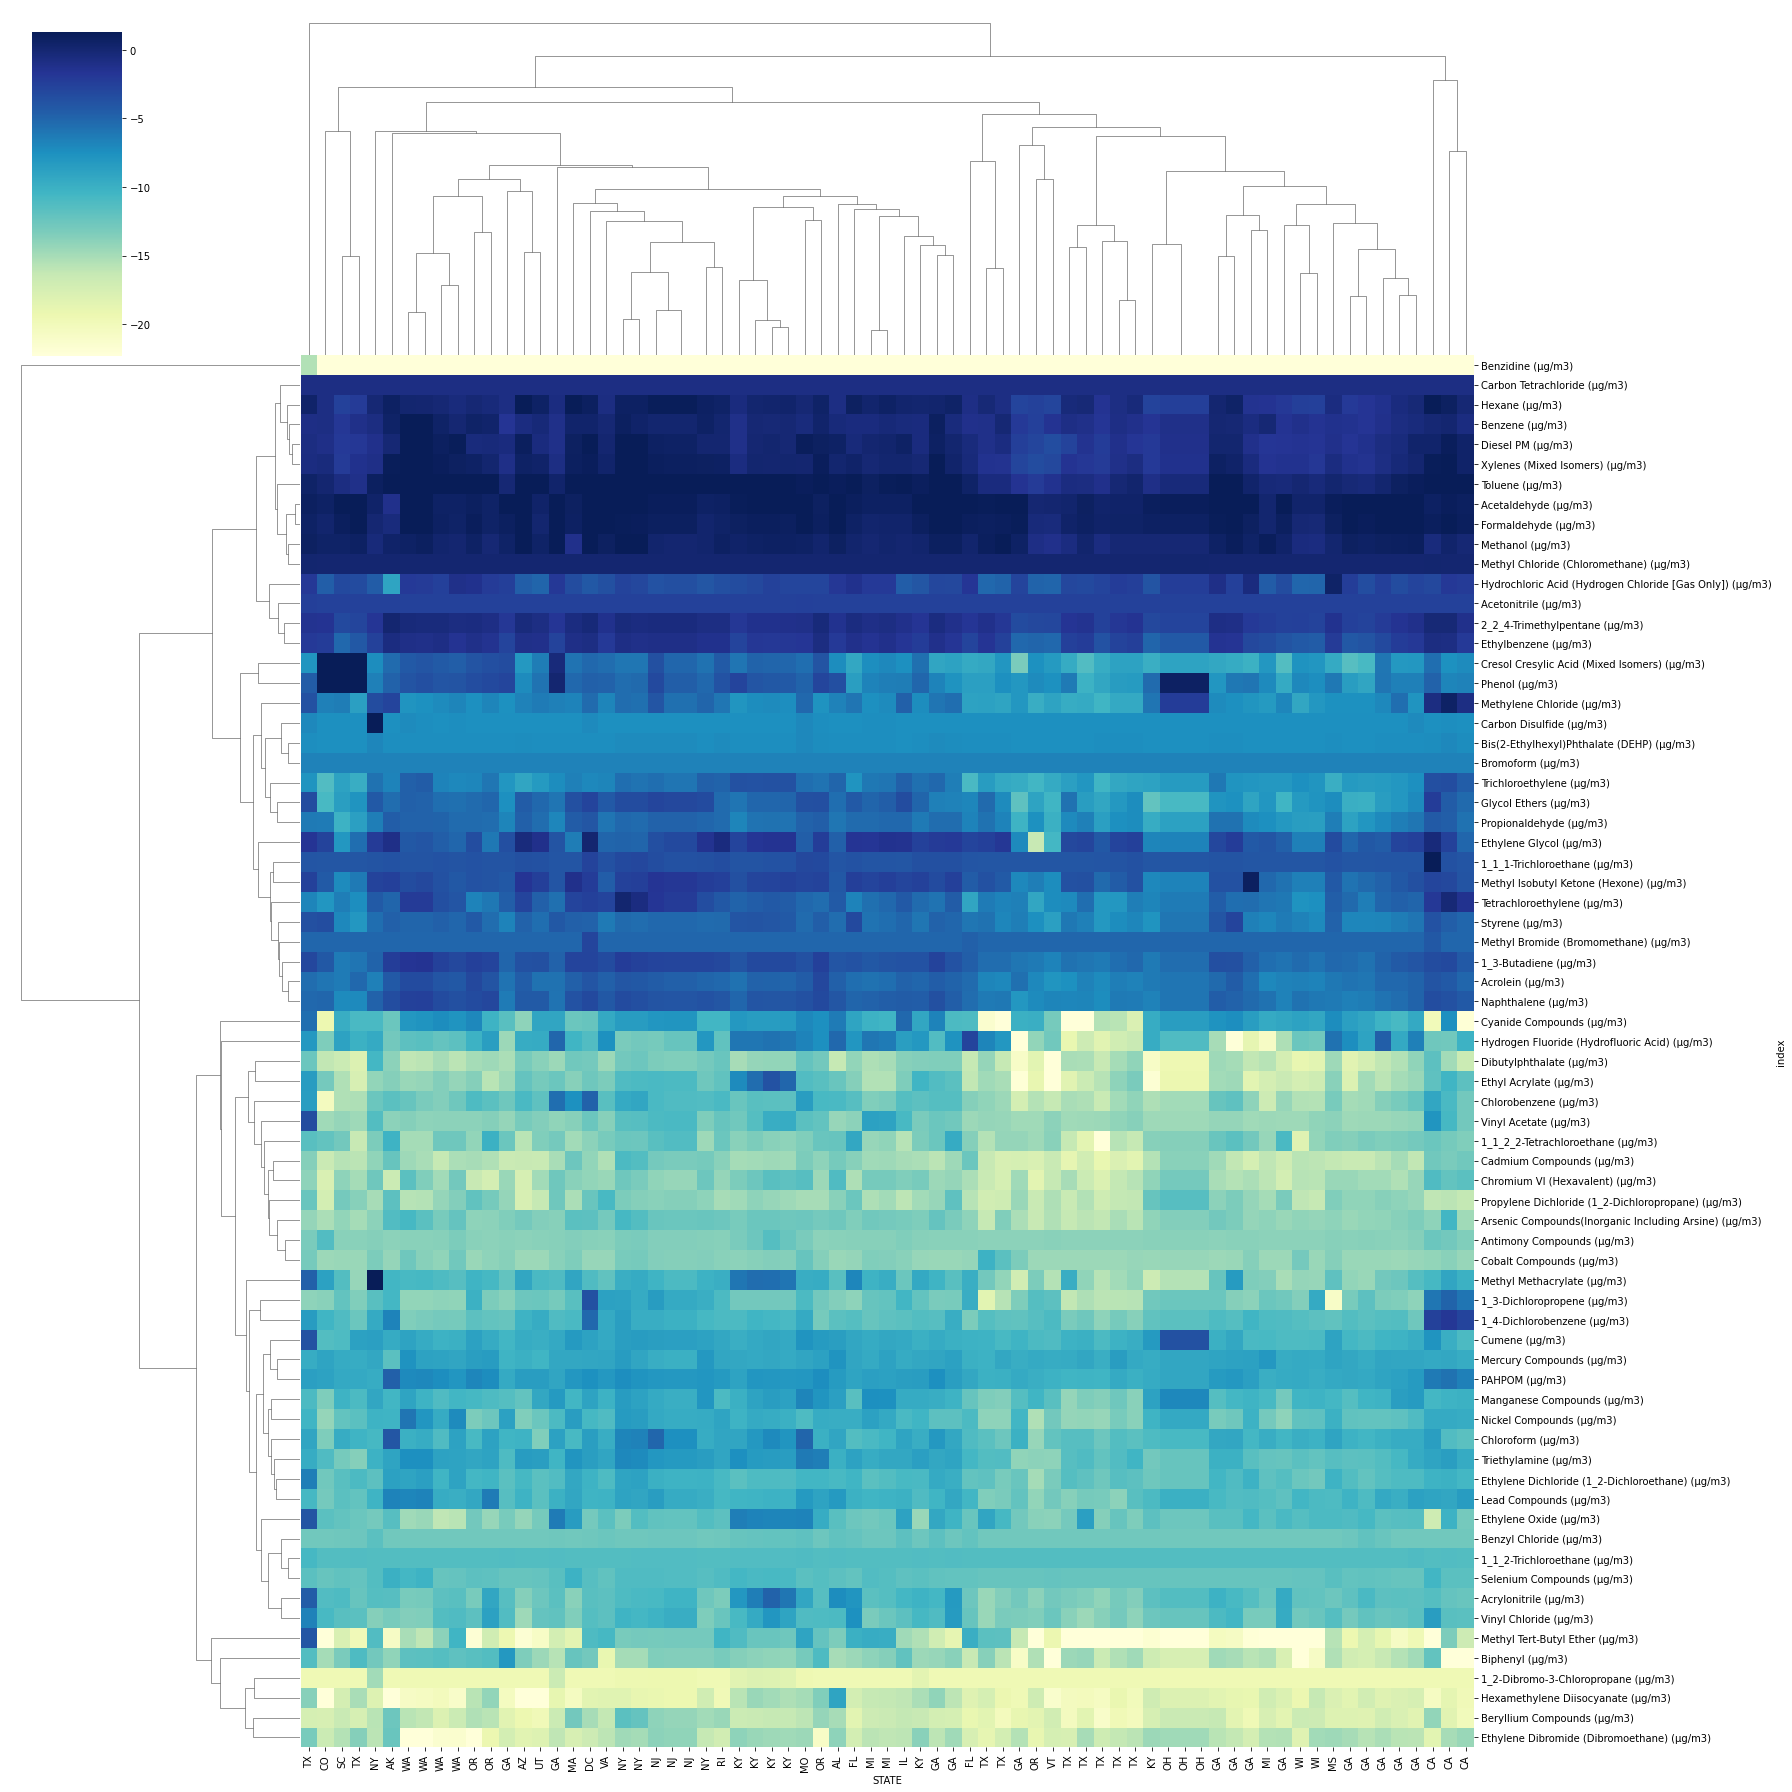

In [154]:
#heirarchical clustering of dataset
sns.clustermap(data_clean, robust = True, figsize=(25,25), cmap = "YlGnBu")

In [155]:
data_t = data_clean.transpose()
data_t

index,1_1_1-Trichloroethane (µg/m3),1_1_2-Trichloroethane (µg/m3),1_1_2_2-Tetrachloroethane (µg/m3),1_2-Dibromo-3-Chloropropane (µg/m3),1_3-Butadiene (µg/m3),1_3-Dichloropropene (µg/m3),1_4-Dichlorobenzene (µg/m3),2_2_4-Trimethylpentane (µg/m3),Acetaldehyde (µg/m3),Acetonitrile (µg/m3),...,Propylene Dichloride (1_2-Dichloropropane) (µg/m3),Selenium Compounds (µg/m3),Styrene (µg/m3),Tetrachloroethylene (µg/m3),Toluene (µg/m3),Trichloroethylene (µg/m3),Triethylamine (µg/m3),Vinyl Acetate (µg/m3),Vinyl Chloride (µg/m3),Xylenes (Mixed Isomers) (µg/m3)
STATE,,,,,,,,,,,,,,,,,,,,,
AK,-3.796887,-11.338465,-10.217871,-19.538592,-2.340012,-10.648289,-6.753184,0.093651,-1.229480,-2.556369,...,-11.772824,-9.952985,-4.697090,-4.975451,2.071746,-6.778786,-9.049164,-13.934613,-13.068544,1.185147
AL,-3.969953,-11.243084,-12.297899,-19.538592,-3.927546,-13.544534,-11.692039,-1.430071,1.711477,-2.556387,...,-13.838581,-11.773373,-5.408999,-4.350237,1.066251,-4.990309,-9.934475,-14.401008,-10.988634,0.210886
AZ,-3.628549,-11.338482,-15.756331,-19.538592,-3.727048,-12.585733,-10.224865,-0.507488,1.633853,-2.556380,...,-17.670790,-12.259394,-4.844642,-2.799794,1.745580,-9.122880,-8.437040,-13.083445,-14.695084,0.637694
CA,-3.691659,-11.298838,-12.990007,-19.538592,-3.182316,-4.927887,-1.876380,-0.163373,1.122677,-2.556290,...,-15.855882,-11.751765,-4.616365,-0.171824,2.381266,-3.454072,-8.581037,-10.742733,-11.595995,1.419904
CA,-3.958038,-11.336614,-13.452792,-19.538592,-4.225048,-5.871919,-2.786328,-1.221850,0.922019,-2.556393,...,-16.258555,-11.711733,-5.058058,-1.350392,1.411888,-4.509569,-9.559866,-12.841998,-11.740161,0.494467
CA,2.172166,-11.338501,-12.453104,-19.538592,-3.287228,-6.020687,-2.552992,-0.171511,0.768978,-2.548995,...,-16.038488,-10.495611,-3.769826,-1.972752,2.125427,-3.557461,-9.039308,-7.820916,-8.487379,1.162658
CO,-4.058894,-11.335073,-12.102761,-19.538592,-4.146058,-13.833838,-10.435447,-1.615615,0.676393,-2.556393,...,-17.271119,-12.286650,-3.431568,-7.941446,0.081072,-11.242580,-11.163244,-14.794828,-10.845807,-0.488981
DC,-2.643089,-11.336866,-13.958841,-19.538592,-2.756964,-3.733962,-5.172656,-0.288660,1.375001,-2.555287,...,-12.386700,-11.544658,-4.788636,-2.518493,2.050149,-7.015564,-8.588743,-12.417910,-11.465921,1.143800
FL,-4.008687,-11.338495,-13.680923,-19.538592,-4.644116,-9.750723,-13.320547,-1.792319,1.351475,-2.556389,...,-15.689538,-12.069423,-5.986275,-9.133285,0.540192,-10.876606,-10.655512,-14.566769,-12.253406,-0.391873


In [156]:
#Assign unique group numbers based upon the index (state) column 
data_t['group'] = data_t.groupby(['STATE']).ngroup()
data_t

index,1_1_1-Trichloroethane (µg/m3),1_1_2-Trichloroethane (µg/m3),1_1_2_2-Tetrachloroethane (µg/m3),1_2-Dibromo-3-Chloropropane (µg/m3),1_3-Butadiene (µg/m3),1_3-Dichloropropene (µg/m3),1_4-Dichlorobenzene (µg/m3),2_2_4-Trimethylpentane (µg/m3),Acetaldehyde (µg/m3),Acetonitrile (µg/m3),...,Selenium Compounds (µg/m3),Styrene (µg/m3),Tetrachloroethylene (µg/m3),Toluene (µg/m3),Trichloroethylene (µg/m3),Triethylamine (µg/m3),Vinyl Acetate (µg/m3),Vinyl Chloride (µg/m3),Xylenes (Mixed Isomers) (µg/m3),group
STATE,,,,,,,,,,,,,,,,,,,,,
AK,-3.796887,-11.338465,-10.217871,-19.538592,-2.340012,-10.648289,-6.753184,0.093651,-1.229480,-2.556369,...,-9.952985,-4.697090,-4.975451,2.071746,-6.778786,-9.049164,-13.934613,-13.068544,1.185147,0
AL,-3.969953,-11.243084,-12.297899,-19.538592,-3.927546,-13.544534,-11.692039,-1.430071,1.711477,-2.556387,...,-11.773373,-5.408999,-4.350237,1.066251,-4.990309,-9.934475,-14.401008,-10.988634,0.210886,1
AZ,-3.628549,-11.338482,-15.756331,-19.538592,-3.727048,-12.585733,-10.224865,-0.507488,1.633853,-2.556380,...,-12.259394,-4.844642,-2.799794,1.745580,-9.122880,-8.437040,-13.083445,-14.695084,0.637694,2
CA,-3.691659,-11.298838,-12.990007,-19.538592,-3.182316,-4.927887,-1.876380,-0.163373,1.122677,-2.556290,...,-11.751765,-4.616365,-0.171824,2.381266,-3.454072,-8.581037,-10.742733,-11.595995,1.419904,3
CA,-3.958038,-11.336614,-13.452792,-19.538592,-4.225048,-5.871919,-2.786328,-1.221850,0.922019,-2.556393,...,-11.711733,-5.058058,-1.350392,1.411888,-4.509569,-9.559866,-12.841998,-11.740161,0.494467,3
CA,2.172166,-11.338501,-12.453104,-19.538592,-3.287228,-6.020687,-2.552992,-0.171511,0.768978,-2.548995,...,-10.495611,-3.769826,-1.972752,2.125427,-3.557461,-9.039308,-7.820916,-8.487379,1.162658,3
CO,-4.058894,-11.335073,-12.102761,-19.538592,-4.146058,-13.833838,-10.435447,-1.615615,0.676393,-2.556393,...,-12.286650,-3.431568,-7.941446,0.081072,-11.242580,-11.163244,-14.794828,-10.845807,-0.488981,4
DC,-2.643089,-11.336866,-13.958841,-19.538592,-2.756964,-3.733962,-5.172656,-0.288660,1.375001,-2.555287,...,-11.544658,-4.788636,-2.518493,2.050149,-7.015564,-8.588743,-12.417910,-11.465921,1.143800,5
FL,-4.008687,-11.338495,-13.680923,-19.538592,-4.644116,-9.750723,-13.320547,-1.792319,1.351475,-2.556389,...,-12.069423,-5.986275,-9.133285,0.540192,-10.876606,-10.655512,-14.566769,-12.253406,-0.391873,6


## Note: This lets us know that they only measured 25 states and we can now illustrate these states as different colors on the clustermap...

In [157]:
#set the index
dfidgroups = data_t
dfidgroups.head(10)

index,1_1_1-Trichloroethane (µg/m3),1_1_2-Trichloroethane (µg/m3),1_1_2_2-Tetrachloroethane (µg/m3),1_2-Dibromo-3-Chloropropane (µg/m3),1_3-Butadiene (µg/m3),1_3-Dichloropropene (µg/m3),1_4-Dichlorobenzene (µg/m3),2_2_4-Trimethylpentane (µg/m3),Acetaldehyde (µg/m3),Acetonitrile (µg/m3),...,Selenium Compounds (µg/m3),Styrene (µg/m3),Tetrachloroethylene (µg/m3),Toluene (µg/m3),Trichloroethylene (µg/m3),Triethylamine (µg/m3),Vinyl Acetate (µg/m3),Vinyl Chloride (µg/m3),Xylenes (Mixed Isomers) (µg/m3),group
STATE,,,,,,,,,,,,,,,,,,,,,
AK,-3.796887,-11.338465,-10.217871,-19.538592,-2.340012,-10.648289,-6.753184,0.093651,-1.229480,-2.556369,...,-9.952985,-4.697090,-4.975451,2.071746,-6.778786,-9.049164,-13.934613,-13.068544,1.185147,0
AL,-3.969953,-11.243084,-12.297899,-19.538592,-3.927546,-13.544534,-11.692039,-1.430071,1.711477,-2.556387,...,-11.773373,-5.408999,-4.350237,1.066251,-4.990309,-9.934475,-14.401008,-10.988634,0.210886,1
AZ,-3.628549,-11.338482,-15.756331,-19.538592,-3.727048,-12.585733,-10.224865,-0.507488,1.633853,-2.556380,...,-12.259394,-4.844642,-2.799794,1.745580,-9.122880,-8.437040,-13.083445,-14.695084,0.637694,2
CA,-3.691659,-11.298838,-12.990007,-19.538592,-3.182316,-4.927887,-1.876380,-0.163373,1.122677,-2.556290,...,-11.751765,-4.616365,-0.171824,2.381266,-3.454072,-8.581037,-10.742733,-11.595995,1.419904,3
CA,-3.958038,-11.336614,-13.452792,-19.538592,-4.225048,-5.871919,-2.786328,-1.221850,0.922019,-2.556393,...,-11.711733,-5.058058,-1.350392,1.411888,-4.509569,-9.559866,-12.841998,-11.740161,0.494467,3
CA,2.172166,-11.338501,-12.453104,-19.538592,-3.287228,-6.020687,-2.552992,-0.171511,0.768978,-2.548995,...,-10.495611,-3.769826,-1.972752,2.125427,-3.557461,-9.039308,-7.820916,-8.487379,1.162658,3
CO,-4.058894,-11.335073,-12.102761,-19.538592,-4.146058,-13.833838,-10.435447,-1.615615,0.676393,-2.556393,...,-12.286650,-3.431568,-7.941446,0.081072,-11.242580,-11.163244,-14.794828,-10.845807,-0.488981,4
DC,-2.643089,-11.336866,-13.958841,-19.538592,-2.756964,-3.733962,-5.172656,-0.288660,1.375001,-2.555287,...,-11.544658,-4.788636,-2.518493,2.050149,-7.015564,-8.588743,-12.417910,-11.465921,1.143800,5
FL,-4.008687,-11.338495,-13.680923,-19.538592,-4.644116,-9.750723,-13.320547,-1.792319,1.351475,-2.556389,...,-12.069423,-5.986275,-9.133285,0.540192,-10.876606,-10.655512,-14.566769,-12.253406,-0.391873,6


Text(0.5, 1.3, 'Hierarchical Clustering of USA States by EPA Measured Atmospheric Chemical Composition')

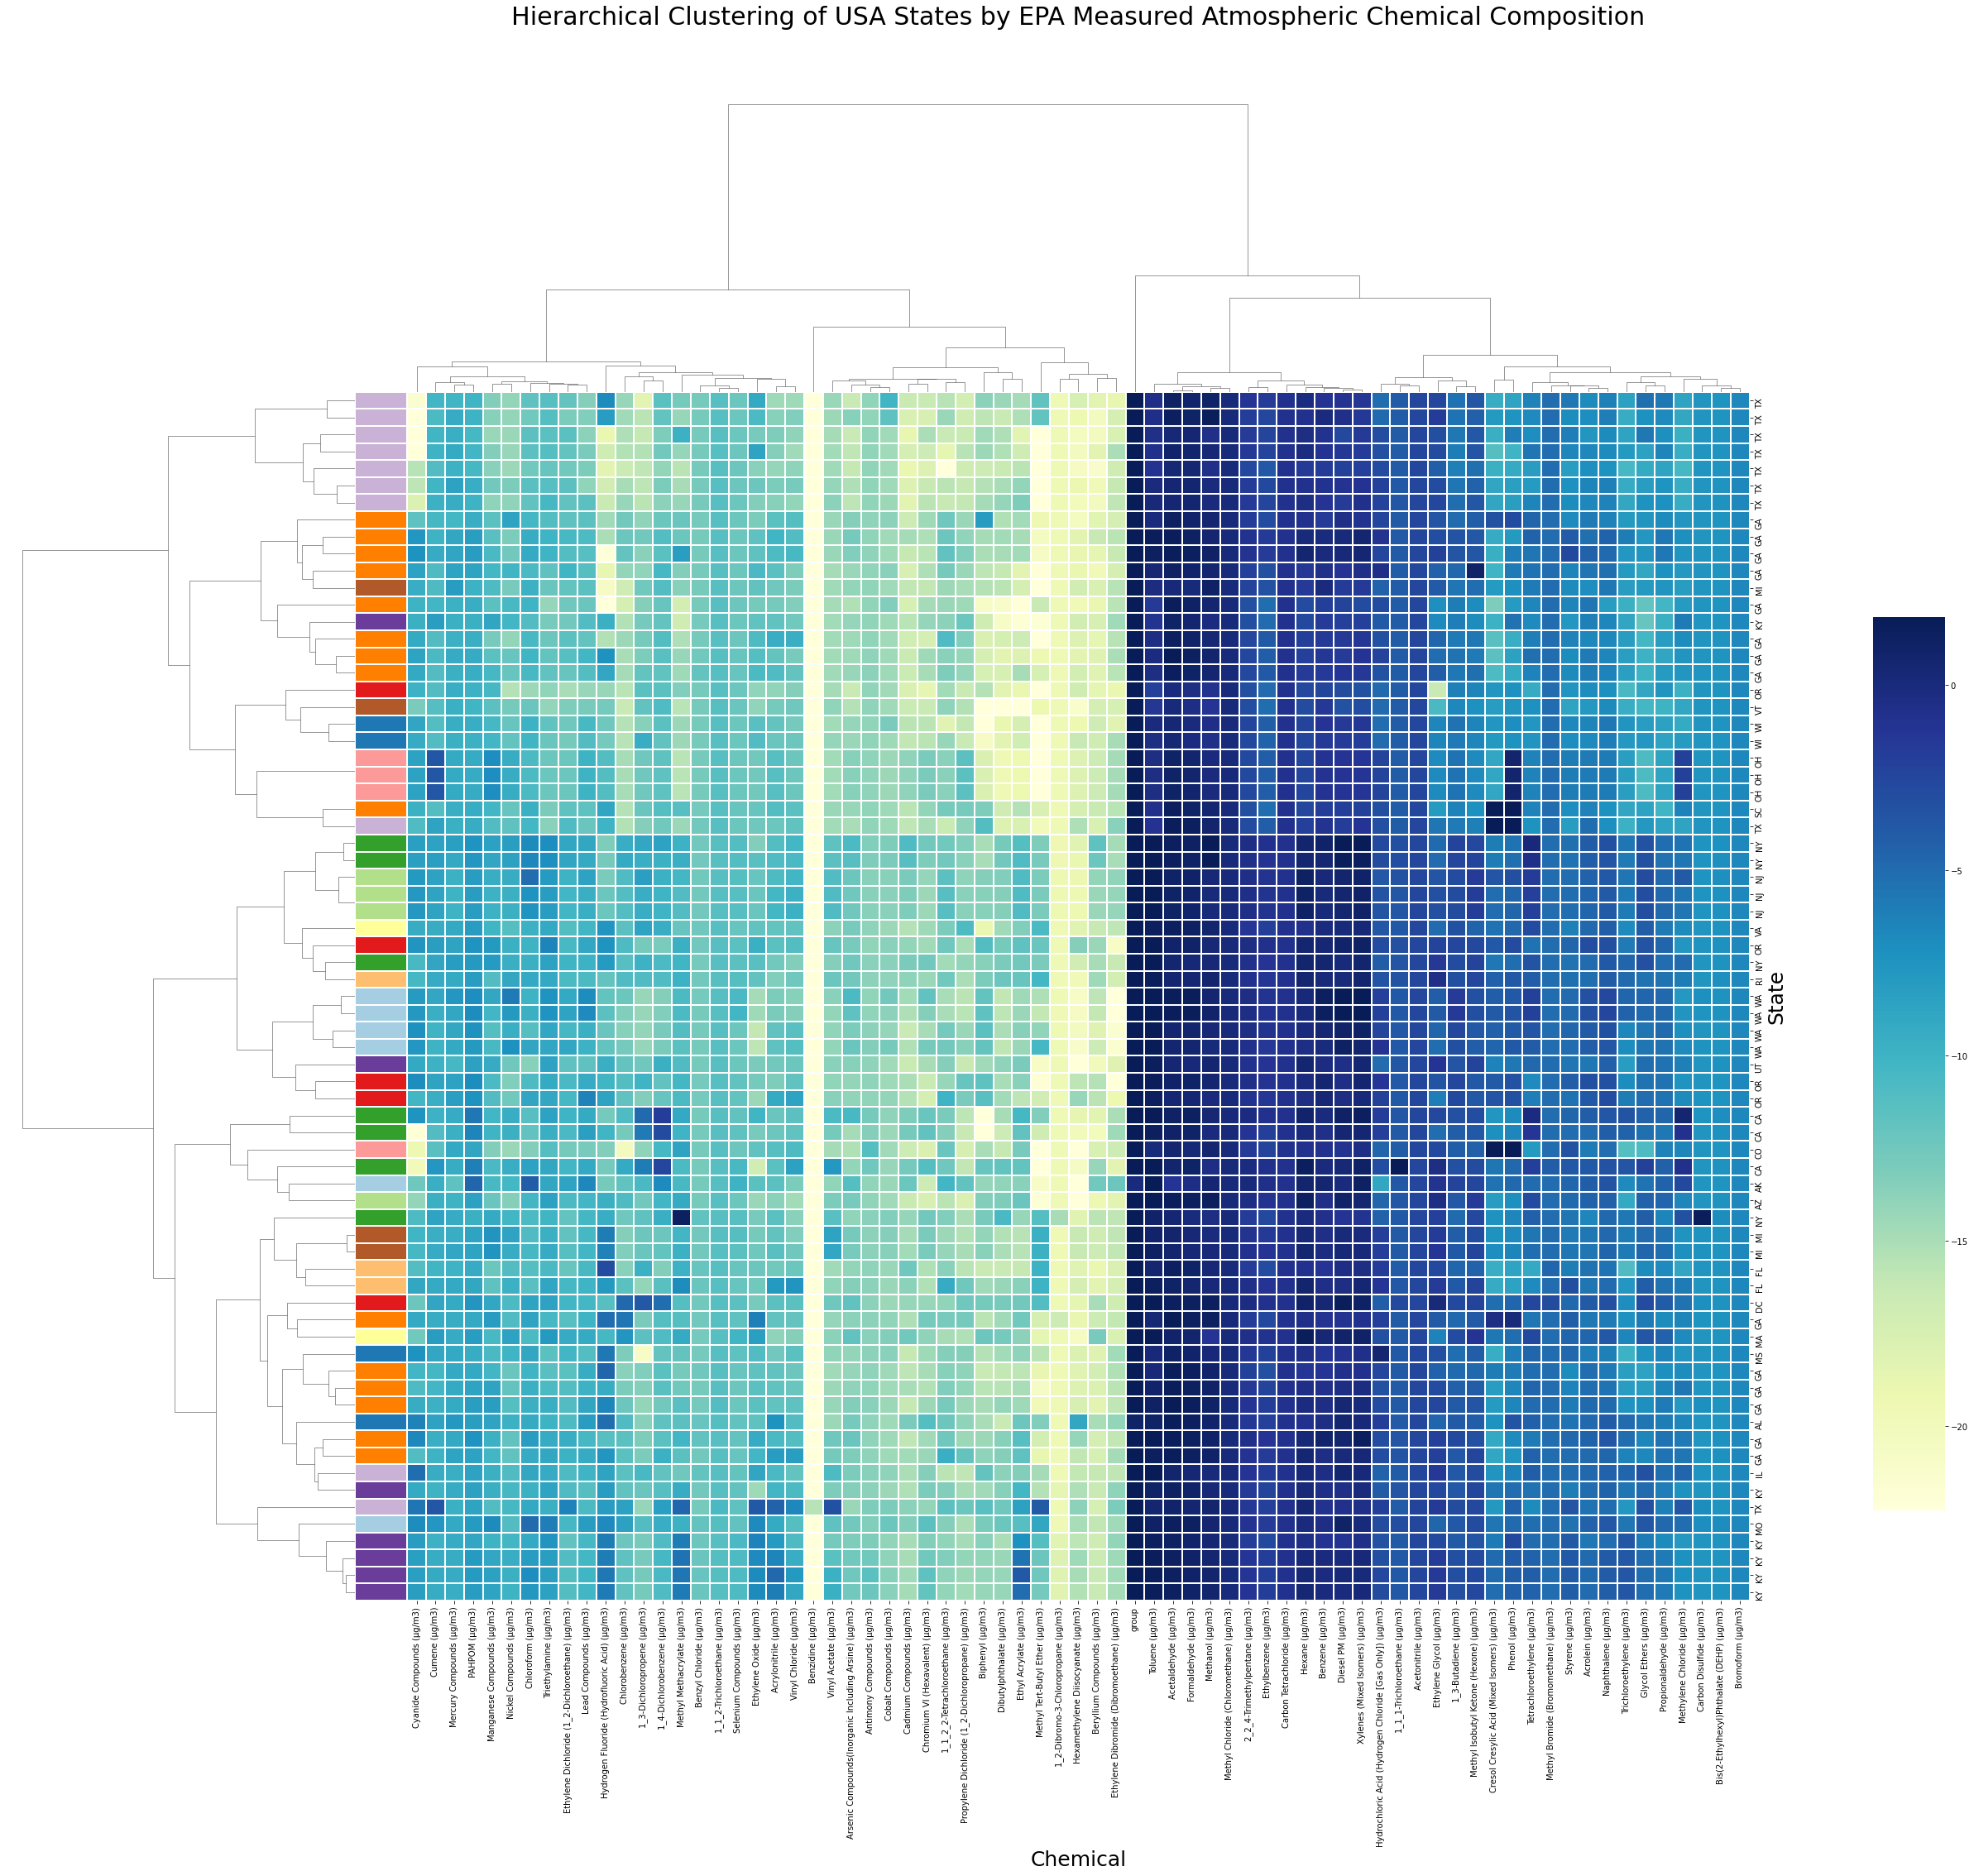

In [158]:
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('Paired', len(dfidgroups.group.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(dfidgroups.group.unique(), network_pal))

#get the series of all of the categories
networks = dfidgroups.group

#map the colors to the series. Now we have a list of colors the same
#length as our dataframe, where unique values are mapped to the same color
network_colors = pd.Series(networks).map(network_lut)

#plot the heatmap with the 16S and ITS categories with the network colors
#defined by Source column
g = sns.clustermap(dfidgroups, method = 'ward', robust = True, figsize=(30,30), cmap = "YlGnBu", linewidths=0.1, cbar_pos=(1.05, .2, .04, .5), row_colors=[network_colors])
ax = g.ax_heatmap
ax.set_xlabel("Chemical", fontsize = 25)
ax.set_ylabel("State", fontsize = 25)
ax.set_title('Hierarchical Clustering of USA States by EPA Measured Atmospheric Chemical Composition', y=1.3, fontsize = 30)

In [163]:
data_clean.head(10)

STATE,AK,AL,AZ,CA,CA,CA,CO,DC,FL,FL,...,TX,UT,VA,VT,WA,WA,WA,WA,WI,WI
index,,,,,,,,,,,,,,,,,,,,,
1_1_1-Trichloroethane (µg/m3),-3.796887,-3.969953,-3.628549,-3.691659,-3.958038,2.172166,-4.058894,-2.643089,-4.008687,-3.798316,...,-4.024433,-3.663098,-3.729315,-4.058518,-3.867341,-3.844676,-3.769895,-3.871994,-4.037055,-4.028913
1_1_2-Trichloroethane (µg/m3),-11.338465,-11.243084,-11.338482,-11.298838,-11.336614,-11.338501,-11.335073,-11.336866,-11.338495,-11.338500,...,-11.321190,-11.338465,-11.333957,-11.338499,-11.337045,-11.338013,-11.338456,-11.337949,-11.338490,-11.338292
1_1_2_2-Tetrachloroethane (µg/m3),-10.217871,-12.297899,-15.756331,-12.990007,-13.452792,-12.453104,-12.102761,-13.958841,-13.680923,-9.355322,...,-18.510574,-13.431661,-13.117491,-13.841973,-14.953249,-14.920073,-12.687180,-12.617442,-18.138880,-14.235909
1_2-Dibromo-3-Chloropropane (µg/m3),-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,...,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592
1_3-Butadiene (µg/m3),-2.340012,-3.927546,-3.727048,-3.182316,-4.225048,-3.287228,-4.146058,-2.756964,-4.644116,-3.817412,...,-6.044512,-3.611149,-3.245413,-6.722766,-1.679886,-1.595628,-2.573657,-3.075451,-5.383198,-5.825888
1_3-Dichloropropene (µg/m3),-10.648289,-13.544534,-12.585733,-4.927887,-5.871919,-6.020687,-13.833838,-3.733962,-9.750723,-14.067893,...,-15.323020,-12.459590,-8.754134,-11.803050,-14.236351,-14.223086,-14.030373,-14.145221,-13.586153,-9.488576
1_4-Dichlorobenzene (µg/m3),-6.753184,-11.692039,-10.224865,-1.876380,-2.786328,-2.552992,-10.435447,-5.172656,-13.320547,-11.409585,...,-12.603076,-9.734505,-9.486649,-10.957095,-13.470012,-13.235477,-12.920360,-13.024263,-11.475933,-11.806463
2_2_4-Trimethylpentane (µg/m3),0.093651,-1.430071,-0.507488,-0.163373,-1.221850,-0.171511,-1.615615,-0.288660,-1.792319,-0.608884,...,-1.503430,-0.829054,-1.343658,-2.998767,-0.342494,-0.472807,-0.491535,-0.773034,-2.468366,-2.687659
Acetaldehyde (µg/m3),-1.229480,1.711477,1.633853,1.122677,0.922019,0.768978,0.676393,1.375001,1.351475,1.010048,...,0.856128,0.442855,1.462948,0.104735,1.627939,1.621608,0.677962,0.616337,0.365015,0.337054


In [164]:
#Export dataframe to csv with index
data_clean.to_csv(r'./chemicalsbystate.csv')

In [169]:
# load data file
df2 = pd.read_excel (r'chemicalsbystate.xlsx', index_col=0)
df2.head(10)

,AK,AL,AZ,CA,CA.1,CA.2,CO,DC,FL,FL.1,...,TX.8,UT,VA,VT,WA,WA.1,WA.2,WA.3,WI,WI.1
index,,,,,,,,,,,,,,,,,,,,,
1_1_1-Trichloroethane (¬µg/m3),-3.796887,-3.969953,-3.628549,-3.691659,-3.958038,2.172166,-4.058894,-2.643089,-4.008687,-3.798316,...,-4.024433,-3.663098,-3.729315,-4.058518,-3.867341,-3.844676,-3.769895,-3.871994,-4.037055,-4.028913
1_1_2-Trichloroethane (¬µg/m3),-11.338465,-11.243084,-11.338482,-11.298838,-11.336614,-11.338501,-11.335073,-11.336866,-11.338495,-11.338500,...,-11.321190,-11.338465,-11.333957,-11.338499,-11.337045,-11.338013,-11.338456,-11.337949,-11.338490,-11.338292
1_1_2_2-Tetrachloroethane (¬µg/m3),-10.217871,-12.297899,-15.756331,-12.990007,-13.452792,-12.453104,-12.102761,-13.958841,-13.680923,-9.355322,...,-18.510574,-13.431661,-13.117491,-13.841973,-14.953249,-14.920073,-12.687180,-12.617442,-18.138880,-14.235909
1_2-Dibromo-3-Chloropropane (¬µg/m3),-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,...,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592
1_3-Butadiene (¬µg/m3),-2.340012,-3.927546,-3.727048,-3.182316,-4.225048,-3.287228,-4.146058,-2.756964,-4.644116,-3.817412,...,-6.044512,-3.611149,-3.245413,-6.722766,-1.679886,-1.595628,-2.573657,-3.075451,-5.383198,-5.825888
1_3-Dichloropropene (¬µg/m3),-10.648289,-13.544534,-12.585733,-4.927887,-5.871919,-6.020687,-13.833838,-3.733962,-9.750723,-14.067893,...,-15.323020,-12.459590,-8.754134,-11.803050,-14.236351,-14.223086,-14.030373,-14.145221,-13.586153,-9.488576
1_4-Dichlorobenzene (¬µg/m3),-6.753184,-11.692039,-10.224865,-1.876380,-2.786328,-2.552992,-10.435447,-5.172656,-13.320547,-11.409585,...,-12.603076,-9.734505,-9.486649,-10.957095,-13.470012,-13.235477,-12.920360,-13.024263,-11.475933,-11.806463
2_2_4-Trimethylpentane (¬µg/m3),0.093651,-1.430071,-0.507488,-0.163373,-1.221850,-0.171511,-1.615615,-0.288660,-1.792319,-0.608884,...,-1.503430,-0.829054,-1.343658,-2.998767,-0.342494,-0.472807,-0.491535,-0.773034,-2.468366,-2.687659
Acetaldehyde (¬µg/m3),-1.229480,1.711477,1.633853,1.122677,0.922019,0.768978,0.676393,1.375001,1.351475,1.010048,...,0.856128,0.442855,1.462948,0.104735,1.627939,1.621608,0.677962,0.616337,0.365015,0.337054


In [ ]:
Binary comparisons - CA vs TX

In [172]:
CA = ['CA', 'CA.1', 'CA.2']
TX = ['TX', 'TX.1','TX.2', 'TX.3', 'TX.4', 'TX.5', 'TX.6', 'TX.7', 'TX.8']

In [173]:
CA_df = df2[CA]
TX_df = df2[TX]

In [174]:
CATX = TwoCategoryMaster(df2,TX_df,CA_df,"TX","CA")
CATX

/Users/jonathan.okerblom/opt/miniconda3/envs/bots/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,AK,AL,AZ,CA,CA.1,CA.2,CO,DC,FL,FL.1,...,WA.3,WI,WI.1,ttest_pvalue,TX Mean,CA Mean,Fold Change(TX/CA),Log2(Fold Change),-Log(P-value),TX/CA pi score
index,,,,,,,,,,,,,,,,,,,,,
1_1_1-Trichloroethane (¬µg/m3),-3.796887,-3.969953,-3.628549,-3.691659,-3.958038,2.172166,-4.058894,-2.643089,-4.008687,-3.798316,...,-3.871994,-4.037055,-4.028913,3.966841e-01,-3.966088,-1.825844,2.172195,1.119153,0.401555,0.449402
1_1_2-Trichloroethane (¬µg/m3),-11.338465,-11.243084,-11.338482,-11.298838,-11.336614,-11.338501,-11.335073,-11.336866,-11.338495,-11.338500,...,-11.337949,-11.338490,-11.338292,3.577560e-01,-11.252226,-11.324651,0.993605,-0.009256,0.446413,-0.004132
1_1_2_2-Tetrachloroethane (¬µg/m3),-10.217871,-12.297899,-15.756331,-12.990007,-13.452792,-12.453104,-12.102761,-13.958841,-13.680923,-9.355322,...,-12.617442,-18.138880,-14.235909,1.053251e-02,-16.437510,-12.965301,1.267808,0.342336,1.977468,0.676959
1_2-Dibromo-3-Chloropropane (¬µg/m3),-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,...,-19.538592,-19.538592,-19.538592,NaN,-19.538592,-19.538592,1.000000,0.000000,NaN,NaN
1_3-Butadiene (¬µg/m3),-2.340012,-3.927546,-3.727048,-3.182316,-4.225048,-3.287228,-4.146058,-2.756964,-4.644116,-3.817412,...,-3.075451,-5.383198,-5.825888,7.184223e-03,-5.385482,-3.564864,1.510712,0.595228,2.143620,1.275944
1_3-Dichloropropene (¬µg/m3),-10.648289,-13.544534,-12.585733,-4.927887,-5.871919,-6.020687,-13.833838,-3.733962,-9.750723,-14.067893,...,-14.145221,-13.586153,-9.488576,4.457965e-08,-15.622808,-5.606831,2.786388,1.478396,7.350863,10.867489
1_4-Dichlorobenzene (¬µg/m3),-6.753184,-11.692039,-10.224865,-1.876380,-2.786328,-2.552992,-10.435447,-5.172656,-13.320547,-11.409585,...,-13.024263,-11.475933,-11.806463,1.978833e-08,-12.306924,-2.405233,5.116728,2.355222,7.703591,18.143663
2_2_4-Trimethylpentane (¬µg/m3),0.093651,-1.430071,-0.507488,-0.163373,-1.221850,-0.171511,-1.615615,-0.288660,-1.792319,-0.608884,...,-0.773034,-2.468366,-2.687659,4.078521e-02,-1.849047,-0.518911,3.563321,1.833222,1.389497,2.547258
Acetaldehyde (¬µg/m3),-1.229480,1.711477,1.633853,1.122677,0.922019,0.768978,0.676393,1.375001,1.351475,1.010048,...,0.616337,0.365015,0.337054,6.722514e-01,0.855005,0.937891,0.911625,-0.133488,0.172468,-0.023022


In [176]:
CATXr = CATX.reset_index()
CATXr.head(10)

,index,AK,AL,AZ,CA,CA.1,CA.2,CO,DC,FL,...,WA.3,WI,WI.1,ttest_pvalue,TX Mean,CA Mean,Fold Change(TX/CA),Log2(Fold Change),-Log(P-value),TX/CA pi score
0,1_1_1-Trichloroethane (¬µg/m3),-3.796887,-3.969953,-3.628549,-3.691659,-3.958038,2.172166,-4.058894,-2.643089,-4.008687,...,-3.871994,-4.037055,-4.028913,3.966841e-01,-3.966088,-1.825844,2.172195,1.119153,0.401555,0.449402
1,1_1_2-Trichloroethane (¬µg/m3),-11.338465,-11.243084,-11.338482,-11.298838,-11.336614,-11.338501,-11.335073,-11.336866,-11.338495,...,-11.337949,-11.338490,-11.338292,3.577560e-01,-11.252226,-11.324651,0.993605,-0.009256,0.446413,-0.004132
2,1_1_2_2-Tetrachloroethane (¬µg/m3),-10.217871,-12.297899,-15.756331,-12.990007,-13.452792,-12.453104,-12.102761,-13.958841,-13.680923,...,-12.617442,-18.138880,-14.235909,1.053251e-02,-16.437510,-12.965301,1.267808,0.342336,1.977468,0.676959
3,1_2-Dibromo-3-Chloropropane (¬µg/m3),-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,-19.538592,...,-19.538592,-19.538592,-19.538592,NaN,-19.538592,-19.538592,1.000000,0.000000,NaN,NaN
4,1_3-Butadiene (¬µg/m3),-2.340012,-3.927546,-3.727048,-3.182316,-4.225048,-3.287228,-4.146058,-2.756964,-4.644116,...,-3.075451,-5.383198,-5.825888,7.184223e-03,-5.385482,-3.564864,1.510712,0.595228,2.143620,1.275944
5,1_3-Dichloropropene (¬µg/m3),-10.648289,-13.544534,-12.585733,-4.927887,-5.871919,-6.020687,-13.833838,-3.733962,-9.750723,...,-14.145221,-13.586153,-9.488576,4.457965e-08,-15.622808,-5.606831,2.786388,1.478396,7.350863,10.867489
6,1_4-Dichlorobenzene (¬µg/m3),-6.753184,-11.692039,-10.224865,-1.876380,-2.786328,-2.552992,-10.435447,-5.172656,-13.320547,...,-13.024263,-11.475933,-11.806463,1.978833e-08,-12.306924,-2.405233,5.116728,2.355222,7.703591,18.143663
7,2_2_4-Trimethylpentane (¬µg/m3),0.093651,-1.430071,-0.507488,-0.163373,-1.221850,-0.171511,-1.615615,-0.288660,-1.792319,...,-0.773034,-2.468366,-2.687659,4.078521e-02,-1.849047,-0.518911,3.563321,1.833222,1.389497,2.547258
8,Acetaldehyde (¬µg/m3),-1.229480,1.711477,1.633853,1.122677,0.922019,0.768978,0.676393,1.375001,1.351475,...,0.616337,0.365015,0.337054,6.722514e-01,0.855005,0.937891,0.911625,-0.133488,0.172468,-0.023022
9,Acetonitrile (¬µg/m3),-2.556369,-2.556387,-2.556380,-2.556290,-2.556393,-2.548995,-2.556393,-2.555287,-2.556389,...,-2.551768,-2.556386,-2.556384,4.133110e-01,-2.537420,-2.553893,0.993550,-0.009336,0.383723,-0.003582


In [181]:
CATXd = CATXr.dropna()
CATXd

,index,AK,AL,AZ,CA,CA.1,CA.2,CO,DC,FL,...,WA.3,WI,WI.1,ttest_pvalue,TX Mean,CA Mean,Fold Change(TX/CA),Log2(Fold Change),-Log(P-value),TX/CA pi score
0,1_1_1-Trichloroethane (¬µg/m3),-3.796887,-3.969953,-3.628549,-3.691659,-3.958038,2.172166,-4.058894,-2.643089,-4.008687,...,-3.871994,-4.037055,-4.028913,3.966841e-01,-3.966088,-1.825844,2.172195,1.119153,0.401555,0.449402
1,1_1_2-Trichloroethane (¬µg/m3),-11.338465,-11.243084,-11.338482,-11.298838,-11.336614,-11.338501,-11.335073,-11.336866,-11.338495,...,-11.337949,-11.338490,-11.338292,3.577560e-01,-11.252226,-11.324651,0.993605,-0.009256,0.446413,-0.004132
2,1_1_2_2-Tetrachloroethane (¬µg/m3),-10.217871,-12.297899,-15.756331,-12.990007,-13.452792,-12.453104,-12.102761,-13.958841,-13.680923,...,-12.617442,-18.138880,-14.235909,1.053251e-02,-16.437510,-12.965301,1.267808,0.342336,1.977468,0.676959
4,1_3-Butadiene (¬µg/m3),-2.340012,-3.927546,-3.727048,-3.182316,-4.225048,-3.287228,-4.146058,-2.756964,-4.644116,...,-3.075451,-5.383198,-5.825888,7.184223e-03,-5.385482,-3.564864,1.510712,0.595228,2.143620,1.275944
5,1_3-Dichloropropene (¬µg/m3),-10.648289,-13.544534,-12.585733,-4.927887,-5.871919,-6.020687,-13.833838,-3.733962,-9.750723,...,-14.145221,-13.586153,-9.488576,4.457965e-08,-15.622808,-5.606831,2.786388,1.478396,7.350863,10.867489
6,1_4-Dichlorobenzene (¬µg/m3),-6.753184,-11.692039,-10.224865,-1.876380,-2.786328,-2.552992,-10.435447,-5.172656,-13.320547,...,-13.024263,-11.475933,-11.806463,1.978833e-08,-12.306924,-2.405233,5.116728,2.355222,7.703591,18.143663
7,2_2_4-Trimethylpentane (¬µg/m3),0.093651,-1.430071,-0.507488,-0.163373,-1.221850,-0.171511,-1.615615,-0.288660,-1.792319,...,-0.773034,-2.468366,-2.687659,4.078521e-02,-1.849047,-0.518911,3.563321,1.833222,1.389497,2.547258
8,Acetaldehyde (¬µg/m3),-1.229480,1.711477,1.633853,1.122677,0.922019,0.768978,0.676393,1.375001,1.351475,...,0.616337,0.365015,0.337054,6.722514e-01,0.855005,0.937891,0.911625,-0.133488,0.172468,-0.023022
9,Acetonitrile (¬µg/m3),-2.556369,-2.556387,-2.556380,-2.556290,-2.556393,-2.548995,-2.556393,-2.555287,-2.556389,...,-2.551768,-2.556386,-2.556384,4.133110e-01,-2.537420,-2.553893,0.993550,-0.009336,0.383723,-0.003582
10,Acrolein (¬µg/m3),-4.277736,-4.755515,-4.513918,-4.264391,-5.056144,-3.887685,-5.887281,-3.952649,-5.328868,...,-4.112907,-6.535110,-6.768420,5.035994e-03,-6.565005,-4.402740,1.491118,0.576395,2.297915,1.324506


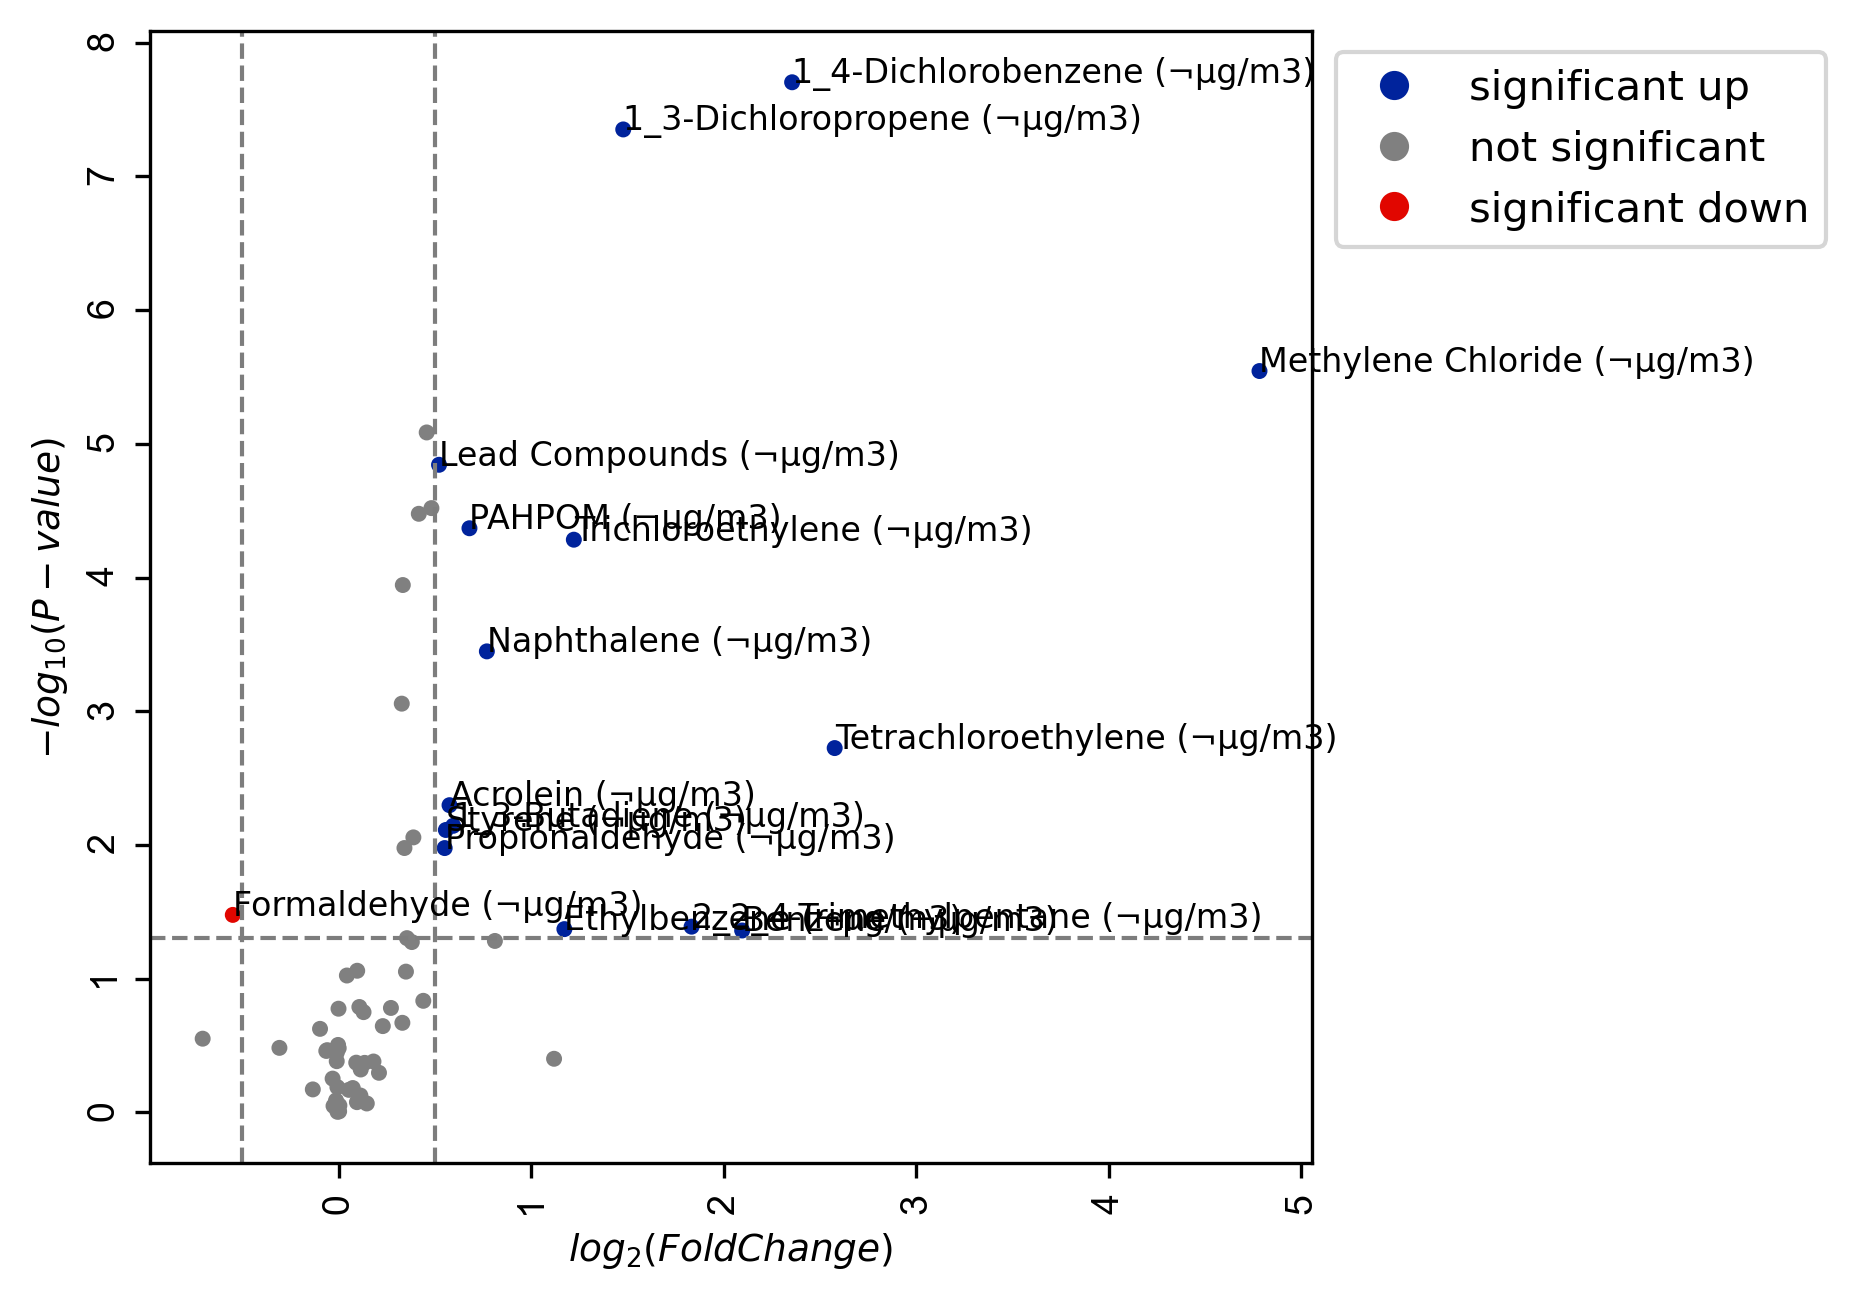

In [184]:
#Visualize binary comparison 
visuz.gene_exp.volcano(df=CATXd, show = True, lfc='Log2(Fold Change)', pv='ttest_pvalue', geneid="index", lfc_thr=(.5, .5), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)